# SolarPower Forecast: Optimizing Energy Consumption and Panel Efficiency

<table>
    <td><img src="https://lh6.googleusercontent.com/proxy/dNeV0QsKmJAG66rXLtBXLeNXbis4GxeWie-_61aYeXk5OGicKzedF3qPdFnCPVV2aTBm7H6kWLkH_6Uo5Q2BsSvEKShO65W44oxCbUhUrxMIrQ9XVQyW" width="500" />
</table>
<sub>Created by: EL KHAMKHOUMI Naoufal, BOUDRIKA Ilias</sub>

<sub>Supervised By: Pr. T.Masrour</sub>



Ce Notebook a pour objectif de développer un modèle de prévision de la consommation d'énergie générée par des panneaux solaires photovoltaïques, afin d'optimiser la production d'énergie et de déterminer le nombre de panneaux nécessaires pour répondre à la demande énergétique, tout en assurant une maintenance prédictive.

<h2><b>Objectif</b></h2>

- **Développer un modèle de prévision** de la consommation d'énergie en utilisant des panneaux solaires photovoltaïques, en exploitant les données historiques de consommation d'énergie et de production solaire.
- **Comparer différentes approches de modélisation** des séries temporelles (ARIMA, LSTM, XGBoost, etc.) pour identifier la méthode la plus performante pour prédire la consommation d'énergie et la production des panneaux solaires.
- **Analyser les tendances et les facteurs d'influence** (ensoleillement, température, encrassement des panneaux, etc.) sur la production d'énergie solaire et la demande en énergie.
- **Évaluer les performances du modèle** à l'aide de métriques appropriées (RMSE, MAE, R²) et optimiser les hyperparamètres pour une meilleure précision dans les prévisions.
- **Utiliser les prévisions pour déterminer le nombre de panneaux solaires nécessaires** afin de répondre aux besoins énergétiques tout en maximisant l'efficacité énergétique, et pour effectuer
une maintenance prédictive en détectant des anomalies éventuelles dans la production d'énergie.

**Veuillez exécuter le code depuis le début, cellule par cellule, pour garantir le bon fonctionnement du Notebook.**



### **À propos des données**

- **Données de consommation électrique :** Issues de [NYC OpenData](https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-Feb-2025-/jr24-e7cr), ces données fournissent l'historique de la consommation et du coût de l'électricité pour divers bâtiments de la ville de New York.  
- **Données de production solaire :** Obtenues à partir du [NSRDB Data Viewer](https://nsrdb.nrel.gov/data-viewer), ces données incluent des indicateurs clés du rayonnement solaire, tels que l'irradiance horizontale globale (GHI), l'irradiance normale directe (DNI) et l'irradiance horizontale diffuse (DHI), permettant d'estimer la production d'énergie solaire.  

# Installation et Importation des Bibliothèques

In [1]:
"""import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all logs
logging.getLogger('tensorflow').setLevel(logging.ERROR)"""

"import logging\nimport os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all logs\nlogging.getLogger('tensorflow').setLevel(logging.ERROR)"

In [2]:
!pip install pvlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 82.9 MB/s eta 0:00:00:00:0100:01


In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pvlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# Importation et Prétraitement des Données

In [4]:
# Windows
df_generated = pd.read_csv("/kaggle/input/solarpower-forecast-data/generated_2009_2023.csv")
df_consumed = pd.read_csv("/kaggle/input/solarpower-forecast-data/Electric_Consumption_And_Cost__2010_-_Feb_2025__20250311.csv")

/tmp/ipykernel_31/3446156935.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_consumed = pd.read_csv("/kaggle/input/solarpower-forecast-data/Electric_Consumption_And_Cost__2010_-_Feb_2025__20250311.csv")


## Données de consommation d'énergie

In [5]:
df_consumed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521035 entries, 0 to 521034
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    520414 non-null  object 
 1   Borough             521035 non-null  object 
 2   Account Name        521035 non-null  object 
 3   Location            507102 non-null  object 
 4   Meter AMR           520266 non-null  object 
 5   Meter Scope         27636 non-null   object 
 6   TDS #               519157 non-null  float64
 7   EDP                 521035 non-null  int64  
 8   RC Code             521035 non-null  object 
 9   Funding Source      521035 non-null  object 
 10  AMP #               518672 non-null  object 
 11  Vendor Name         521035 non-null  object 
 12  UMIS BILL ID        521035 non-null  int64  
 13  Revenue Month       521035 non-null  object 
 14  Service Start Date  521027 non-null  object 
 15  Service End Date    521027 non-nul

In [6]:
import os

In [7]:
df_consumed = df_consumed[['Revenue Month', 'Current Charges' ,'Consumption (KWH)']] # Récupérer les données pertinentes

df_consumed.rename(columns={'Revenue Month': 'Datetime', 'Current Charges': 'Cost ($)'}, inplace=True) # Renommer la colonne Revenue Month en Datetime

df_consumed.set_index('Datetime', inplace=True) # Mettre la colonne Datetime en index

df_consumed # Verifier les premières lignes

,Cost ($),Consumption (KWH)
Datetime,,
1/1/2011,15396.82,128800.0
2/1/2011,14556.34,115200.0
3/1/2011,13904.98,103200.0
4/1/2011,14764.04,105600.0
5/1/2011,13729.54,97600.0
...,...,...
12/1/2023,9687.94,78631.0
12/1/2023,12049.22,97796.0
12/1/2023,3280.56,0.0


In [8]:
df_consumed.index = pd.to_datetime(df_consumed.index) # Convertir l'index en datetime

df_consumed

,Cost ($),Consumption (KWH)
Datetime,,
2011-01-01,15396.82,128800.0
2011-02-01,14556.34,115200.0
2011-03-01,13904.98,103200.0
2011-04-01,14764.04,105600.0
2011-05-01,13729.54,97600.0
...,...,...
2023-12-01,9687.94,78631.0
2023-12-01,12049.22,97796.0
2023-12-01,3280.56,0.0


Nos données sont réparties sur différentes parties de New York, nous allons donc les regrouper ensemble.

In [9]:
df_consumed_grouped = df_consumed.groupby(df_consumed.index).sum()
df_consumed_grouped

,Cost ($),Consumption (KWH)
Datetime,,
2011-01-01,12932094.95,1.062983e+08
2011-02-01,11474423.62,9.313955e+07
2011-03-01,11459508.91,8.847798e+07
2011-04-01,12390753.92,8.907660e+07
2011-05-01,12631326.74,8.963793e+07
...,...,...
2023-08-01,22825232.80,1.199489e+08
2023-09-01,19754972.09,9.811615e+07
2023-10-01,11873141.33,7.680215e+07


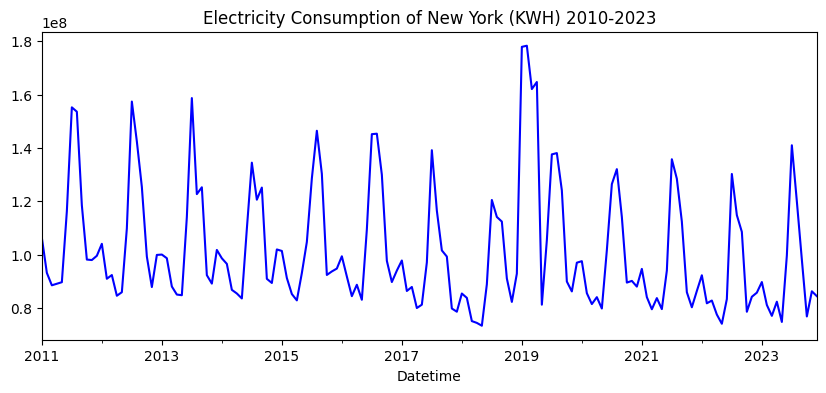

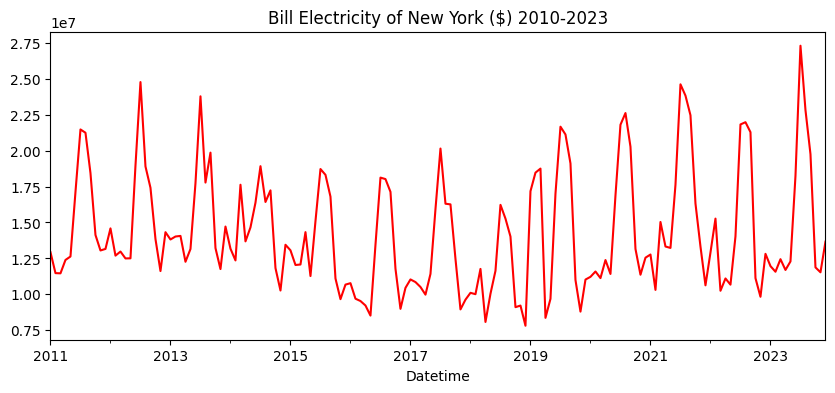

In [10]:
# Plot Consumption (KWH)
df_consumed_grouped['Consumption (KWH)'].plot(figsize=(10, 4), title='Electricity Consumption of New York (KWH) 2010-2023', color='blue')
plt.show()

# Plot Cost ($)
df_consumed_grouped['Cost ($)'].plot(figsize=(10, 4), title='Bill Electricity of New York ($) 2010-2023', color='red')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


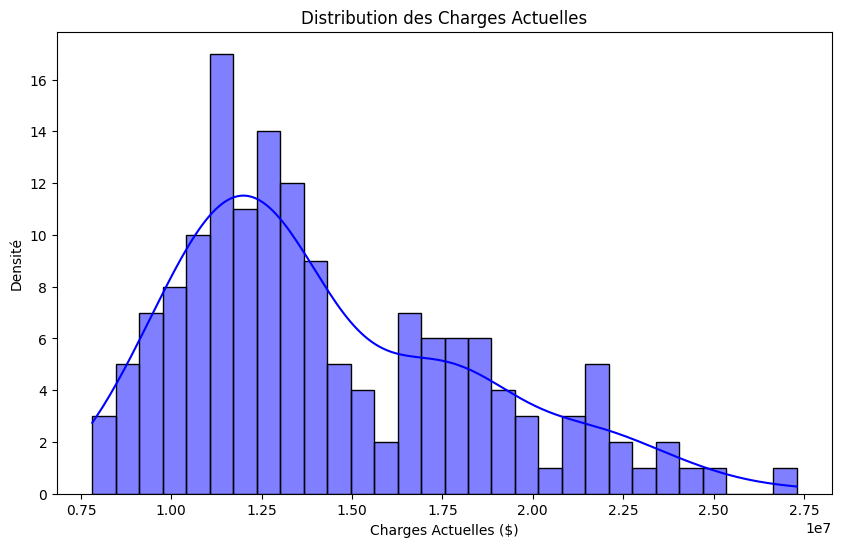

In [11]:
# Tracer la distribution des charges actuelles en utilisant histplot
plt.figure(figsize=(10, 6))
sns.histplot(data = df_consumed_grouped['Cost ($)'], kde=True, bins=30, color='blue')

plt.title('Distribution des Charges Actuelles')
plt.xlabel('Charges Actuelles ($)')
plt.ylabel('Densité')

plt.show()

### Data Augmentation

Dans notre dataset, nous avons des données à fréquence mensuelle. Pour obtenir plus de points de données et affiner notre analyse, nous allons convertir ces données en une fréquence hebdomadaire.

Cette conversion nous permettra de mieux capturer les tendances et les variations à une échelle de temps plus détaillée. Pour ce faire, nous allons utiliser la technique de *resampling* pour regrouper les données par semaine, puis appliquer une méthode d'*interpolation* pour estimer les valeurs manquantes entre les points mensuels.

Cette approche nous donnera des données hebdomadaires sur lesquelles nous pourrons effectuer des analyses plus fines.

### Méthode :

1. **Resampling** : Nous allons changer la fréquence des données de mensuelle à hebdomadaire.
2. **Interpolation** : Nous allons estimer les valeurs manquantes en utilisant les valeurs existantes.

Cette transformation nous fournira une vue plus détaillée de l'évolution des variables au fil du temps.

In [12]:
# Ajouter de l'aléatoire pour rendre les données plus réalistes
def creer_donnees_hebdomadaires_avec_variation(donnees_mensuelles, date_debut='2010-01-01', variation=0.15):
    np.random.seed(42)
    donnees_hebdomadaires = []
    index_dates = []
    date_courante = pd.to_datetime(date_debut)

    for valeur_mensuelle in donnees_mensuelles:
        # Déterminer le nombre de semaines dans le mois
        semaines = 4 + np.random.choice([0, 1])  # 4 ou 5 semaines

        # Générer des facteurs de variation
        variations = np.random.normal(loc=1.0, scale=variation, size=semaines)
        variations = variations / variations.sum()  # Normalisation

        # Appliquer les variations aux valeurs hebdomadaires
        valeurs_semaine = valeur_mensuelle * variations

        # Ajouter les données hebdomadaires
        for valeur in valeurs_semaine:
            donnees_hebdomadaires.append(valeur)
            index_dates.append(date_courante)
            date_courante += timedelta(days=7)

    return pd.Series(donnees_hebdomadaires, index=index_dates)

In [13]:
# Générer les données hebdomadaires
Weekly_energy_consumed = creer_donnees_hebdomadaires_avec_variation(df_consumed_grouped['Consumption (KWH)'])
Weekly_energy_cost= creer_donnees_hebdomadaires_avec_variation(df_consumed_grouped['Cost ($)'])

Weekly_energy_consumed


2010-01-01    2.283354e+07
2010-01-08    2.681183e+07
2010-01-15    2.665663e+07
2010-01-22    2.999627e+07
2010-01-29    1.963609e+07
                  ...     
2023-05-12    1.731015e+07
2023-05-19    2.222881e+07
2023-05-26    2.127110e+07
2023-06-02    1.803241e+07
2023-06-09    2.287144e+07
Length: 702, dtype: float64

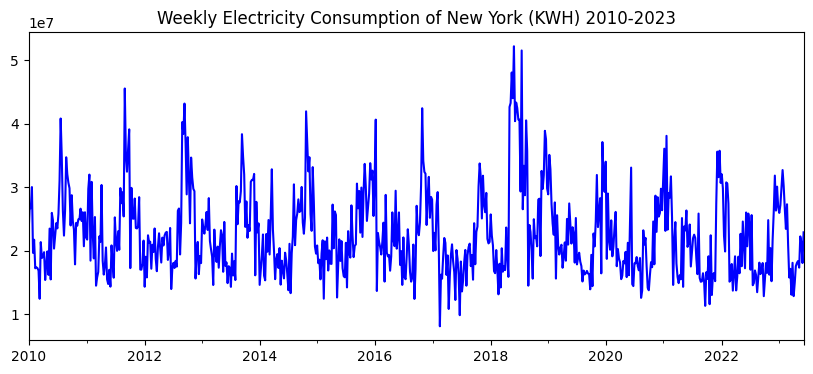

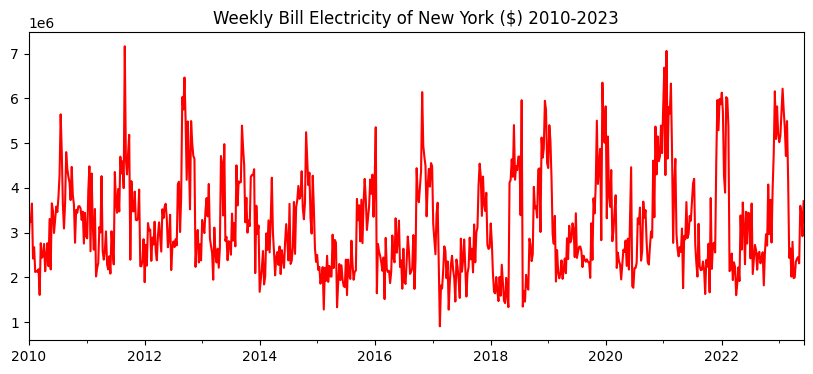

In [14]:
# Plot Consumption (KWH)
Weekly_energy_consumed.plot(figsize=(10, 4), title='Weekly Electricity Consumption of New York (KWH) 2010-2023', color='blue')
plt.show()

# Plot Cost ($)
Weekly_energy_cost.plot(figsize=(10, 4), title='Weekly Bill Electricity of New York ($) 2010-2023', color='red')
plt.show()

## Données de generation d'énergie

In [15]:
df_generated = df_generated[(df_generated['Year'] >= 2010) & (df_generated['Year'] <= 2023)] # Normaliser les données entre 2010 et 2021


<h3><b>Concernant les données</b></h3>

Le dataset est composé de :  

**Variables de radiation solaire :**

- **DHI** (Irradiance Diffuse Horizontale) – *(W/m²)*  
- **DNI** (Irradiance Normale Directe) – *(W/m²)*  
- **GHI** (Irradiance Globale Horizontale) – *(W/m²)*  

**Conditions météorologiques :**  
- **Température** *(°C)*  
- **Angle Zénithal Solaire** *(°)* – Indique la position du soleil par rapport à la verticale. Un angle élevé signifie que le soleil est bas dans le ciel, ce qui réduit l’irradiance reçue.  

In [16]:
df_generated # Afficher les données générées

,Year,Month,Day,Hour,Minute,Temperature,Solar Zenith Angle,GHI,DHI,DNI
8760,2010,1,1,0,30,0.7,121.59,0,0,0
8761,2010,1,1,1,30,0.5,132.94,0,0,0
8762,2010,1,1,2,30,0.2,144.05,0,0,0
8763,2010,1,1,3,30,0.2,154.18,0,0,0
8764,2010,1,1,4,30,0.2,161.23,0,0,0
...,...,...,...,...,...,...,...,...,...,...
131467,2023,12,31,19,30,5.8,72.75,43,43,0
131468,2023,12,31,20,30,4.7,80.32,13,13,0
131469,2023,12,31,21,30,3.9,89.08,3,3,0
131470,2023,12,31,22,30,3.7,99.63,0,0,0


In [17]:
# Convertir les colonnes de temps en un format datetime
df_generated['Datetime'] = pd.to_datetime(df_generated[['Year', 'Month', 'Day', 'Hour']])

# Définir la colonne datetime comme index du DataFrame
df_generated.set_index('Datetime', inplace=True)

# Supprimer les colonnes d'origine liées au temps, car elles sont maintenant redondantes
df_generated.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

# Afficher les premières lignes du DataFrame pour vérifier le résultat
print(df_generated.head())

                     Temperature  Solar Zenith Angle  GHI  DHI  DNI
Datetime                                                           
2010-01-01 00:00:00          0.7              121.59    0    0    0
2010-01-01 01:00:00          0.5              132.94    0    0    0
2010-01-01 02:00:00          0.2              144.05    0    0    0
2010-01-01 03:00:00          0.2              154.18    0    0    0
2010-01-01 04:00:00          0.2              161.23    0    0    0


In [18]:
df_generated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122712 entries, 2010-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Temperature         122712 non-null  float64
 1   Solar Zenith Angle  122712 non-null  float64
 2   GHI                 122712 non-null  int64  
 3   DHI                 122712 non-null  int64  
 4   DNI                 122712 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 5.6 MB


# Irradiance en Plan des Modules (POA)

## Qu'est-ce que l'irradiance POA ?
L'irradiance en plan des modules (Plane of Array - POA) désigne la quantité de rayonnement solaire reçue par une surface inclinée, comme un panneau solaire, plutôt qu'une surface horizontale. Elle est essentielle pour estimer avec précision la production d'énergie des systèmes photovoltaïques (PV), car les panneaux solaires sont généralement installés à un angle et non à plat.

L'irradiance POA comprend trois composantes principales :
1. **Irradiance directe (beam)** : Lumière solaire atteignant directement le panneau sans diffusion.
2. **Irradiance diffuse** : Lumière solaire diffusée par l’atmosphère et reçue depuis plusieurs directions.
3. **Irradiance réfléchie (albédo)** : Lumière solaire réfléchie par le sol ou des surfaces environnantes vers le panneau.

## Méthode de calcul
L’irradiance POA ($ G_{POA} $) est obtenue en additionnant les contributions de ces trois composantes :

$$
G_{POA} = G_{b,POA} + G_{d,POA} + G_{r,POA}
$$

Où :
- $ G_{b,POA} $ = Irradiance normale directe (DNI - Direct Normal Irradiance)
- $ G_{d,POA} $ = Irradiance horizontale diffuse (DHI - Diffuse Horizontal Irradiance)
- $ G_{r,POA} $ = Irradiance réfléchie par le sol

Avec :

**<h4>1. l'angle d'incidence (AOI) :</h4>**

$$
\cos(\theta) = \cos(\beta) \sin(E) + \sin(\beta) \cos(E) \cos(A_s - A_p)
$$

Où :  
- $E$ = Angle d'élévation solaire  
- $A_s$ = Angle azimutal du soleil  
- $A_p$ = Angle azimutal du panneau  
- $\beta$ = Angle d'inclinaison du panneau  

**<h4>2. Composante directe de l'irradiance POA :</h4>**

$$
G_{b, POA} = G_b \cos(\theta)
$$

Où $G_b$ est l'**irradiance normale directe (DNI)**.

**<h4>3. Composante diffuse de l'irradiance POA (Modèle isotropique)</h4>**

$$
G_{d, POA} = G_d \times \frac{1 + \cos(\beta)}{2}
$$

Où $G_d$ est l'**irradiance horizontale diffuse (DHI)**.

**<h4>4. Composante réfléchie de l'irradiance POA (Albédo)</h4>**
$$
G_{r, POA} = G \times \rho \times \frac{1 - \cos(\beta)}{2}
$$

Où :  
- $G$ = **Irradiance horizontale globale (GHI)**  
- $\rho$ = **Albédo (coefficient de réflexion du sol)**

Le calcul de l’irradiance POA permet une meilleure estimation des performances des panneaux solaires dans des conditions réelles..


Pour l'angle d'élévation solaire (SEA), nous pouvons utiliser l'angle de zenith solaire (SZA) pour le calculer avec la formule suivante :  
$$ SEA = 90^\circ - SZA $$

Pour l'angle d'azimut solaire, nous allons utiliser la bibliothèque `pvlib` afin de l'extraire avec précision.

In [19]:
# Calcule de l'angle d'elevation solaire
df_generated["Solar Elevation"] = 90 - df_generated["Solar Zenith Angle"]

# Define location coordinates (Pour notre dataset: New York City)
latitude = 40.73
longitude = -74.02

# Generate an hourly datetime range from 2010 to 2023
time_range = pd.date_range(start="2010-01-01", end="2023-12-31 23:00:00", freq="H")

# Calculate solar position using pvlib
solar_positions = pvlib.solarposition.get_solarposition(time_range, latitude, longitude)

# Extract azimuth values
solar_azimuth = solar_positions['azimuth']

# Create a DataFrame to store results
df_azimuth = pd.DataFrame({'Datetime': time_range, "Solar Azimuth": solar_azimuth})

# Display first rows
print(df_azimuth.head())

/tmp/ipykernel_31/2429804742.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start="2010-01-01", end="2023-12-31 23:00:00", freq="H")


                               Datetime  Solar Azimuth
2010-01-01 00:00:00 2010-01-01 00:00:00     261.078818
2010-01-01 01:00:00 2010-01-01 01:00:00     270.376425
2010-01-01 02:00:00 2010-01-01 02:00:00     281.270480
2010-01-01 03:00:00 2010-01-01 03:00:00     296.102129
2010-01-01 04:00:00 2010-01-01 04:00:00     320.278205


In [20]:
merged_df = pd.merge(df_generated, df_azimuth[['Datetime', "Solar Azimuth"]], on='Datetime', how='left') # Combiner Azimuth et les données générées

merged_df.set_index('Datetime', inplace=True) # Définir la colonne datetime comme index du DataFrame


merged_df = merged_df.drop(columns=['Solar Zenith Angle']) # Car on a deja calculer le SEA

# Afficher les premières lignes du DataFrame pour vérifier le résultat
print(merged_df)

                     Temperature  GHI  DHI  DNI  Solar Elevation  \
Datetime                                                           
2010-01-01 00:00:00          0.7    0    0    0           -31.59   
2010-01-01 01:00:00          0.5    0    0    0           -42.94   
2010-01-01 02:00:00          0.2    0    0    0           -54.05   
2010-01-01 03:00:00          0.2    0    0    0           -64.18   
2010-01-01 04:00:00          0.2    0    0    0           -71.23   
...                          ...  ...  ...  ...              ...   
2023-12-31 19:00:00          5.8   43   43    0            17.25   
2023-12-31 20:00:00          4.7   13   13    0             9.68   
2023-12-31 21:00:00          3.9    3    3    0             0.92   
2023-12-31 22:00:00          3.7    0    0    0            -9.63   
2023-12-31 23:00:00          3.7    0    0    0           -20.44   

                     Solar Azimuth  
Datetime                            
2010-01-01 00:00:00     261.078818  
2010

<Axes: title={'center': 'Irradiation globale [W/m2] en fonction du temps'}, xlabel='Datetime', ylabel='Irradiation globale [W/m2]'>

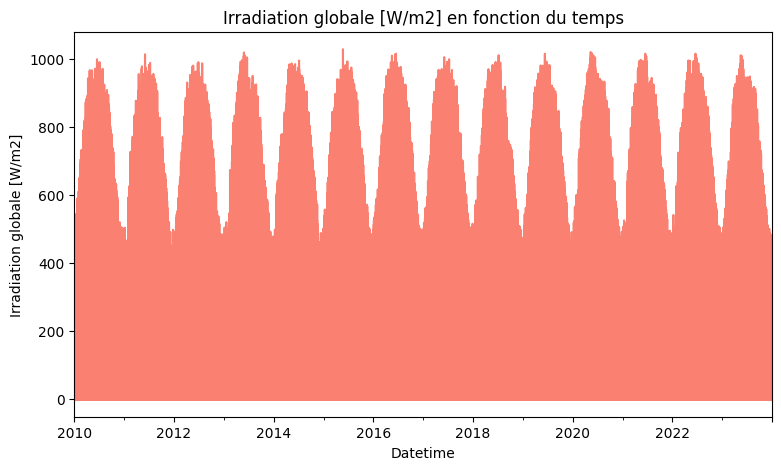

In [21]:
# Calculer l'irradiance globale du Plan de l'Array (POA)

# Définir l'angle d'inclinaison du panneau solaire (bêta) en degrés
beta = 5

# Définir l'angle d'azimut du panneau solaire (azimut) en degrés
azimut = 180

# Définir l'albédo (rho) de l'environnement environnant
rho = 0.2

# Convertir l'angle d'élévation du soleil en radians
elevation = np.radians(merged_df['Solar Elevation'])

# Convertir l'angle d'azimut du soleil en radians
azimut_s = np.radians(merged_df['Solar Azimuth'])

# Calculer le cosinus de l'angle d'incidence (cos_aoi)
cos_aoi = np.cos((np.pi/180)*beta) * np.sin(elevation) + np.sin((np.pi/180)*beta) * np.cos(elevation) * np.cos(azimut_s - azimut)

# Calculer le composant direct de l'irradiance POA (poa_b)
poa_b = np.clip(merged_df['DNI'] * cos_aoi, 0, None)

# Calculer le composant diffus de l'irradiance POA (poa_d)
poa_d = np.clip(merged_df['DHI'] * (1 + np.cos(beta*np.pi/180)) / 2, 0, None)

# Calculer le composant réfléchi de l'irradiance POA (poa_r)
poa_r = np.clip(merged_df['GHI'] * rho * (1 - np.cos(beta*np.pi/180)) / 2, 0, None)

# Calculer l'irradiance globale totale POA (gpoa) en additionnant les composants direct, diffus et réfléchi
gpoa = poa_b + poa_d + poa_r

# Tracer l'irradiance globale POA au fil du temps
gpoa.plot(title=("Irradiation globale [W/m2] en fonction du temps"), ylabel=("Irradiation globale [W/m2]"), figsize=(9,5), color=('salmon'))

# Calcul de la Température de la Cellule et de la Puissance

Dans cette section, nous allons estimer la température de la cellule et la puissance générée par les panneaux solaires à l'aide de deux modèles : le **modèle de Ross** pour la température et le **modèle PVWatts** pour la puissance DC. Nous utiliserons l'irradiance POA et la température ambiante comme principales variables.

### 1. **Calcul de la Température de la Cellule**
La température de la cellule solaire ($T_c$) est calculée en utilisant le **modèle de Ross**. Ce modèle relie la température de la cellule à la température ambiante ($T_a$) et à l'irradiance. L’équation utilisée est la suivante :

$$
T_c = T_a + k_{\text{ross}} \times G_{\text{POA}}
$$

Où :
- $T_a$ = Température ambiante (en °C)  
- $k_{\text{ross}}$ = Coefficient de température, calculé à partir de la température nominale de fonctionnement de la cellule (NOCT) et d’une irradiance de référence de 800 W/m²
- $G_{\text{POA}}$ = Irradiance globale reçue par le panneau (en W/m²)

Nous récupérons la température ambiante ($T_a$) à partir des données d’entrée et appliquons la formule pour obtenir la température de la cellule.


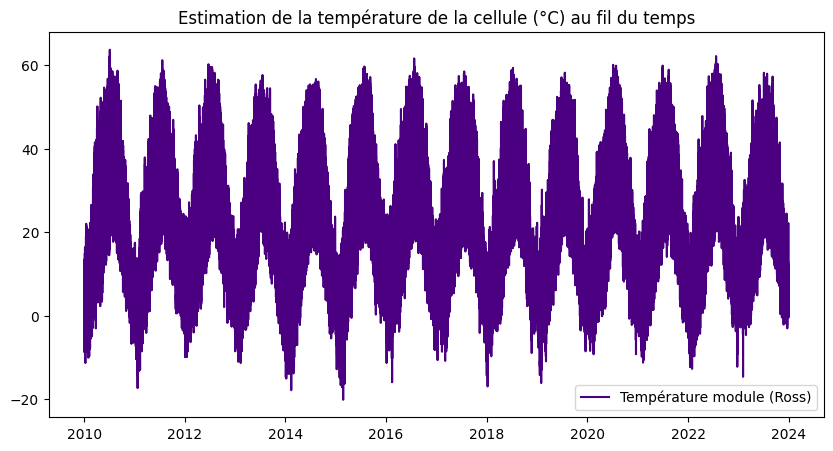

In [22]:
# Calculer la température de la cellule

# Récupérer la température ambiante (Ta) à partir des données d'entrée
Ta = merged_df['Temperature']

# Définir la température nominale de fonctionnement de la cellule (Noct) en °C
Noct = 43

# Calculer le coefficient de température (kross) pour le modèle de Ross
kross = (Noct - 20) / 800

# Modèle de Ross : calculer la température de la cellule (Tc_ross) en utilisant la température ambiante, le coefficient de température, et l'irradiance globale
Tc_ross = Ta + kross * gpoa

# Tracer les estimations de la température des cellules des deux modèles au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(Tc_ross, label='Température module (Ross)', color='indigo')  # Tracer le modèle de Ross
plt.title('Estimation de la température de la cellule (°C) au fil du temps')  # Définir le titre du graphique
plt.legend()  # Afficher la légende

### 2. **Calcul de la Puissance DC**
La **puissance DC** générée par les panneaux solaires est ensuite estimée à l’aide du **modèle PVWatts**. Ce modèle prend en compte l'irradiance et la température pour ajuster la puissance générée par rapport aux conditions réelles. L’équation utilisée est la suivante :

$$
P_{\text{DC}} = P_{dc0} \times \left( \frac{G_{\text{POA}}}{1000} \right) \times \left(1 + \gamma_{\text{coief}} \times (T_c - 25)\right)
$$

Où :
- $P_{dc0}$ = Puissance de référence en watts (ici, 300 W par [panneau](https://www.enfsolar.com/pv/panel-datasheet/crystalline/65662?utm_source=ENF&utm_medium=panel_profile&utm_campaign=enquiry_company_directory&utm_content=77684) multiplié par le nombre de panneaux)
- $G_{\text{POA}}$ = Irradiance globale du plan des modules
- $\gamma_{\text{coief}}$ = Coefficient de température de la puissance DC
- $T_c$ = Température de la cellule

Pour référence, prenons une petite station avec 10 000 panneaux de 750 W chacun. La station Noor Ouarzazate, l'une des plus grandes centrales solaires au monde, possède environ 200 000 panneaux.

**Panneau de reference:** [SR6-HJT725-750M](https://www.enfsolar.com/pv/panel-datasheet/crystalline/65662?utm_source=ENF&utm_medium=panel_profile&utm_campaign=enquiry_company_directory&utm_content=77684)

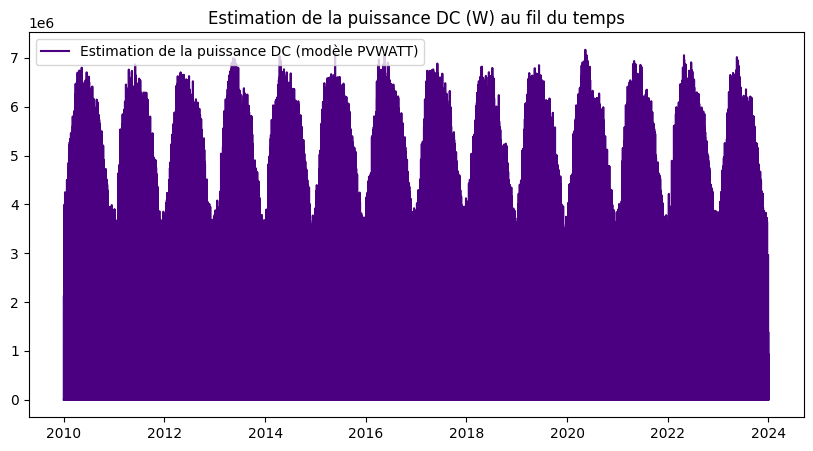

In [23]:
# Calculer la puissance continue (DC)

# Définir la puissance DC de référence (Pdc0) en watts
Pdc0 = 750 * 10000  # 750 W par panneau * 10000 panneaux

# Définir le coefficient de température (gamma_coief) pour le modèle PVWatts
gamma_coief = -0.0037

# Calculer l'irradiance normalisée (g_prime) en divisant l'irradiance du plan de l'array (gpoa) par 1000
g_prime = gpoa / 1000

# Calculer la température normalisée (T_prime) en soustrayant 25 de la température de la cellule (Tc_ross)
T_prime = Tc_ross - 25

# Modèle de puissance PVWatts : calculer la puissance DC (Pdc_watts) en utilisant la puissance de référence, l'irradiance, et la température
Pdc_watts = Pdc0 * (gpoa / 1000) * (1 + gamma_coief * (Tc_ross - 25))

# Tracer les estimations de la puissance DC des deux modèles au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(Pdc_watts, label='Estimation de la puissance DC (modèle PVWATT)', color='indigo')  # Tracer le modèle PVWatts
plt.title('Estimation de la puissance DC (W) au fil du temps')
plt.legend()

### 3. **Conversion de la Puissance DC en Puissance AC**
La **puissance AC** est ensuite calculée à partir de la puissance DC en utilisant l'efficacité de l'onduleur ($\eta$) :

$$
P_{\text{AC}} = P_{\text{DC}} \times \eta
$$

Où :
- $\eta$ = Efficacité de l'onduleur (valeur typique entre 0.85 et 0.95)

Le modèle de conversion de la puissance DC en AC prend en compte les pertes d'efficacité dues à l'onduleur.

Ces étapes permettront d'estimer la température des cellules et la puissance générée par les panneaux solaires au fil du temps.

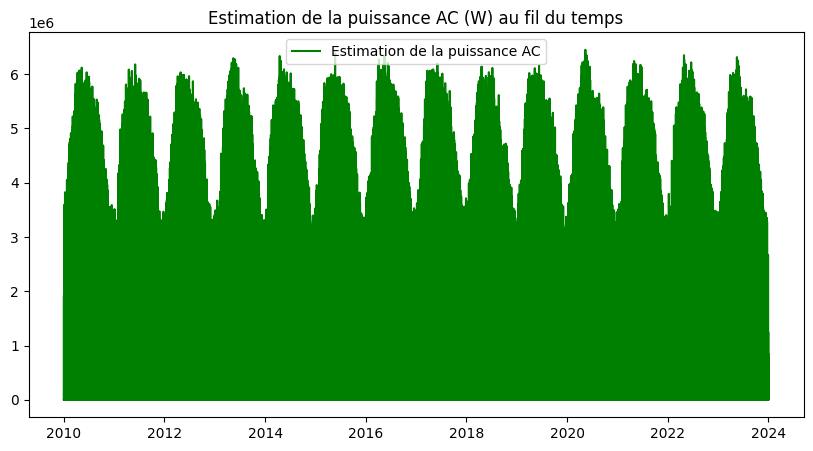

In [24]:
# Définir l'efficacité de l'onduleur (efficacité typique entre 0.85 et 0.95)
eta = 0.9

# Calculer la puissance AC (P_ac) en utilisant la puissance DC (P_dc) et l'efficacité de l'onduleur
P_ac = Pdc_watts * eta

# Tracer les estimations de la puissance AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(P_ac, label='Estimation de la puissance AC', color='green')  # Tracer la puissance AC estimée
plt.title('Estimation de la puissance AC (W) au fil du temps')  # Définir le titre du graphique
plt.legend()  # Afficher la légende

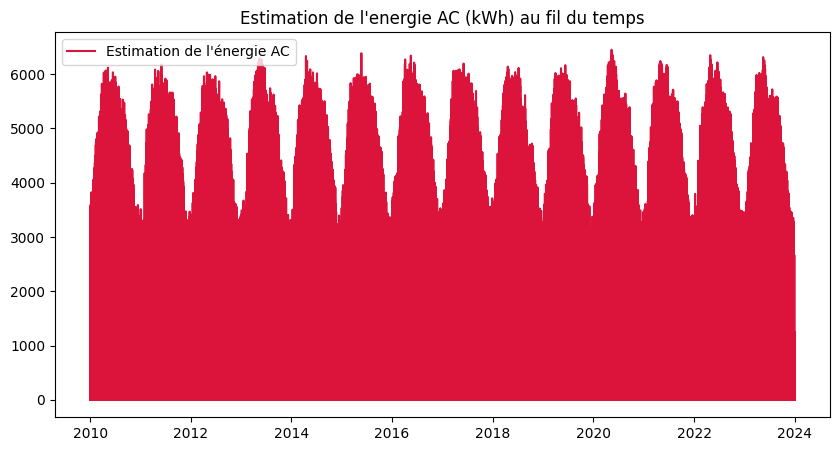

In [25]:
# Puisque la puissance est déjà exprimée par heure, l'énergie (Wh) reste la même. Nous allons simplement la convertir en kWh.
E_ac = P_ac /1000

# Tracer les estimations de l'energie AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(E_ac, label="Estimation de l'énergie AC", color='crimson')  # Tracer la puissance AC estimée
plt.title("Estimation de l'energie AC (kWh) au fil du temps")  # Définir le titre du graphique
plt.legend()  # Afficher la légende

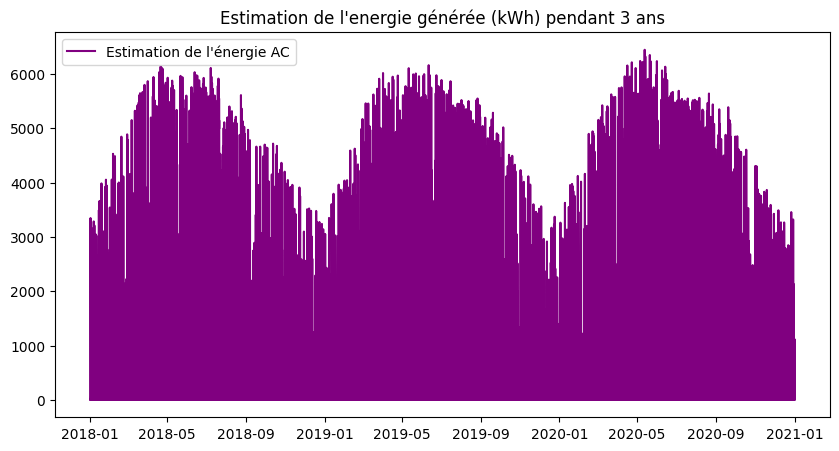

In [26]:
# Tracer les estimations de la puissance AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(E_ac['2018':'2020'], label="Estimation de l'énergie AC", color='Purple')  # Tracer la puissance AC estimée
plt.title("Estimation de l'energie générée (kWh) pendant 3 ans")  # Définir le titre du graphique
plt.legend()  # Afficher la légende

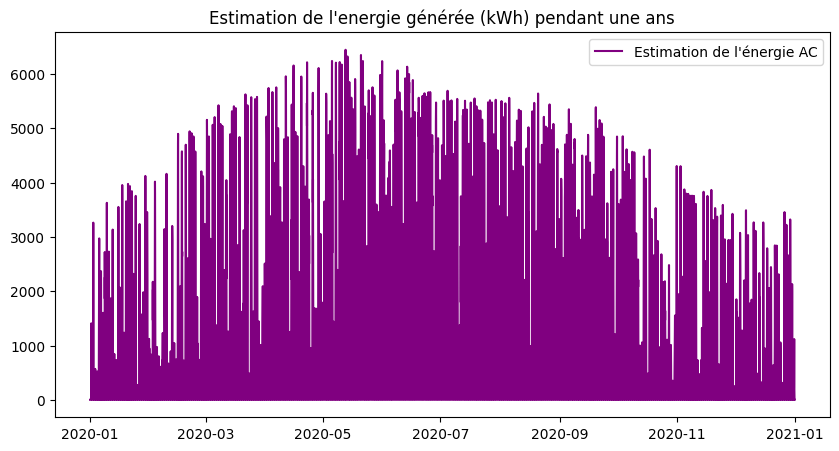

In [27]:
# Tracer les estimations de la puissance AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(E_ac['2020'], label="Estimation de l'énergie AC", color='Purple')  # Tracer la puissance AC estimée
plt.title("Estimation de l'energie générée (kWh) pendant une ans")  # Définir le titre du graphique
plt.legend()  # Afficher la légende

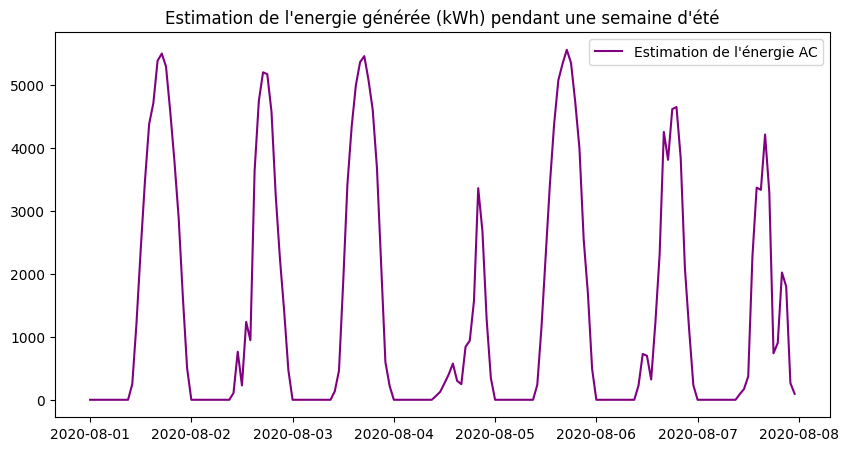

In [28]:
# Tracer les estimations de la puissance AC au fil du temps
plt.figure(figsize=(10, 5))
plt.plot(E_ac['2020-08-01':'2020-08-07'], label="Estimation de l'énergie AC", color='Purple')  # Tracer la puissance AC estimée
plt.title("Estimation de l'energie générée (kWh) pendant une semaine d'été")  # Définir le titre du graphique
plt.legend()  # Afficher la légende

# Later

In [29]:
"""# Paramètres pour creation de windowed data
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000 """

'# Paramètres pour creation de windowed data\nwindow_size = 20\nbatch_size = 32\nshuffle_buffer_size = 1000 '

In [30]:
"""def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    Génère les fenêtres du jeu de données

    Arguments:
      series (tableau de flottants) - contient les valeurs de la série temporelle
      window_size (int) - le nombre de pas de temps à moyenner
      batch_size (int) - la taille du lot
      shuffle_buffer (int) - taille du tampon à utiliser pour la méthode de mélange

    Retourne:
      dataset (TF Dataset) - Jeu de données TensorFlow contenant des fenêtres temporelles


    # Générer un jeu de données TensorFlow à partir des valeurs de la série
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Fenêtrer les données mais ne prendre que celles de la taille spécifiée
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Aplatir les fenêtres en plaçant ses éléments dans un seul lot
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Créer des tuples avec des caractéristiques et des étiquettes
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Mélanger les fenêtres
    dataset = dataset.shuffle(shuffle_buffer)

    # Créer des lots de fenêtres
    dataset = dataset.batch(batch_size)

    # Optimiser le jeu de données pour l'entraînement
    dataset = dataset.cache().prefetch(1)

    return dataset"""

"def windowed_dataset(series, window_size, batch_size, shuffle_buffer):\n    Génère les fenêtres du jeu de données\n\n    Arguments:\n      series (tableau de flottants) - contient les valeurs de la série temporelle\n      window_size (int) - le nombre de pas de temps à moyenner\n      batch_size (int) - la taille du lot\n      shuffle_buffer (int) - taille du tampon à utiliser pour la méthode de mélange\n\n    Retourne:\n      dataset (TF Dataset) - Jeu de données TensorFlow contenant des fenêtres temporelles\n\n\n    # Générer un jeu de données TensorFlow à partir des valeurs de la série\n    dataset = tf.data.Dataset.from_tensor_slices(series)\n\n    # Fenêtrer les données mais ne prendre que celles de la taille spécifiée\n    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)\n\n    # Aplatir les fenêtres en plaçant ses éléments dans un seul lot\n    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))\n\n    # Créer des tuples avec des cara

In [31]:
"""# Générer les fenêtres du jeu de données
dataset = windowed_dataset(normalized_series, window_size, batch_size, shuffle_buffer_size)"""

'# Générer les fenêtres du jeu de données\ndataset = windowed_dataset(normalized_series, window_size, batch_size, shuffle_buffer_size)'

# Introduction sur les séries temporelle

**Une série temporelle** est une séquence de données collectées à intervalles réguliers et ordonnée chronologiquement. La série temporelle peut être décomposée en trois composants principaux :

1.   **Trend $(T)$:** Long-term movement in the data.
2.   **Saisonnalité $(S)$ :** Cycles courts et répétitifs dans les données.
3.   **Bruit $(N)$ :** Variations irrégulières ou aléatoires.

$$ y_t = T_t + S_t + N_t $$

Dans nos données, on peut remarquer une saisonnalité quotidienne ainsi qu'une saisonnalité annuelle., nous allons explorer cela plus en détail dans la prochaine partie.

# Construction du Model
Pour la construction du **modèle**, nous allons d'abord expérimenter avec différentes approches de **séries temporelles** pour faire une prédiction. Nous commencerons par utiliser un **pipeline** pour explorer et déterminer quel **modèle** est le plus adapté aux données. Ce processus nous permettra de prédire les valeurs futures basées sur les données passées, en tenant compte de l'autocorrélation, de la tendance, et éventuellement de la saisonnalité. Ensuite, nous ajusterons **les paramètres du modèle sélectionné** pour obtenir la meilleure performance.

## Pipeline d’Analyse d’une Serie Temporelle
![Solar Panel](./resources/pipeline.png)

## Analyse de stationnarité
L'analyse de stationnarité est cruciale en time series car beaucoup de modèles (ARIMA, etc.) supposent une stationnarité. Une série non stationnaire peut contenir des tendances ou saisonnalités qui faussent les prévisions. On utilise des tests comme **KPSS** pour la détecter et on la transforme (différenciation, log, etc.) si nécessaire. 🚀

In [32]:
E_generated = E_ac
E_consumed = Weekly_energy_consumed
e_cout = Weekly_energy_cost

In [33]:
# Définir les séries à tester
series = {
    "Énergie générée": E_generated,
    "Énergie consommée": E_consumed,
    "Coût d'énergie": e_cout
}

# Effectuer les tests KPSS et ADF pour chaque série et afficher les résultats
for name, data in series.items():
    print('--------------------------------------------------------')
    # Test KPSS
    kpss_stat, kpss_p_value, _, _ = kpss(data, regression='ct', nlags="auto")  # 'ct' (constant et tendance)
    print(f"\n🔍 Résultats du test KPSS pour {name}:")
    print(f"   - KPSS Statistic: {kpss_stat:.4f}")
    print(f"   - P-value: {kpss_p_value:.4f}")

    # Interprétation du test KPSS
    if kpss_p_value < 0.05:
        print("   ❌ Rejet de H0 → La série est NON stationnaire 📉")
    else:
        print("   ✅ On ne rejette pas H0 → La série est stationnaire 📊")

    # Test ADF
    adf_stat, adf_p_value, _, _, _, _ = adfuller(data)
    print(f"\n🔍 Résultats du test ADF pour {name}:")
    print(f"   - ADF Statistic: {adf_stat:.4f}")
    print(f"   - P-value: {adf_p_value:.4f}")

    # Interprétation du test ADF
    if adf_p_value < 0.05:
        print("   ✅ Rejet de H0 → La série est stationnaire 📊")
    else:
        print("   ❌ On ne rejette pas H0 → La série est NON stationnaire 📉")


--------------------------------------------------------

🔍 Résultats du test KPSS pour Énergie générée:
   - KPSS Statistic: 0.0445
   - P-value: 0.1000
   ✅ On ne rejette pas H0 → La série est stationnaire 📊


/tmp/ipykernel_31/1433411821.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_value, _, _ = kpss(data, regression='ct', nlags="auto")  # 'ct' (constant et tendance)



🔍 Résultats du test ADF pour Énergie générée:
   - ADF Statistic: -18.6766
   - P-value: 0.0000
   ✅ Rejet de H0 → La série est stationnaire 📊
--------------------------------------------------------

🔍 Résultats du test KPSS pour Énergie consommée:
   - KPSS Statistic: 0.0499
   - P-value: 0.1000
   ✅ On ne rejette pas H0 → La série est stationnaire 📊

🔍 Résultats du test ADF pour Énergie consommée:
   - ADF Statistic: -7.9073
   - P-value: 0.0000
   ✅ Rejet de H0 → La série est stationnaire 📊
--------------------------------------------------------

🔍 Résultats du test KPSS pour Coût d'énergie:
   - KPSS Statistic: 0.1238
   - P-value: 0.0911
   ✅ On ne rejette pas H0 → La série est stationnaire 📊

🔍 Résultats du test ADF pour Coût d'énergie:
   - ADF Statistic: -8.0875
   - P-value: 0.0000
   ✅ Rejet de H0 → La série est stationnaire 📊


/tmp/ipykernel_31/1433411821.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_value, _, _ = kpss(data, regression='ct', nlags="auto")  # 'ct' (constant et tendance)


### Interprétation des résultats des tests

Les trois **tests KPSS** et **ADF** indiquent que la série est **stationnaire**. Toutefois, nous savons qu’elle présente une **saisonnalité journalière** liée à l’alternance **jour/nuit** ainsi qu’une **saisonnalité annuelle** due aux **variations saisonnières**.

## Analyse de la structure temporelle

L'objectif de cette section est d'examiner la structure temporelle de la série afin d'identifier les caractéristiques essentielles qui guideront la modélisation. Pour cela, nous analyserons :

- **Autocorrélation et autocorrélation partielle** :  
  - La fonction d'autocorrélation (ACF) permet d'observer la dépendance entre les observations à différents décalages (lags).  
  - La fonction d'autocorrélation partielle (PACF) aide à identifier l'ordre potentiel des modèles AR et MA.  

- **Décomposition de la série** :  
  - Séparation en composantes : tendance, saisonnalité et résidu.  
  - Identification de la présence de cycles ou de structures spécifiques.  

Cette analyse nous permettra d’orienter le choix des modèles adaptés (ARIMA, SARIMA, etc.) en fonction des caractéristiques détectées.  

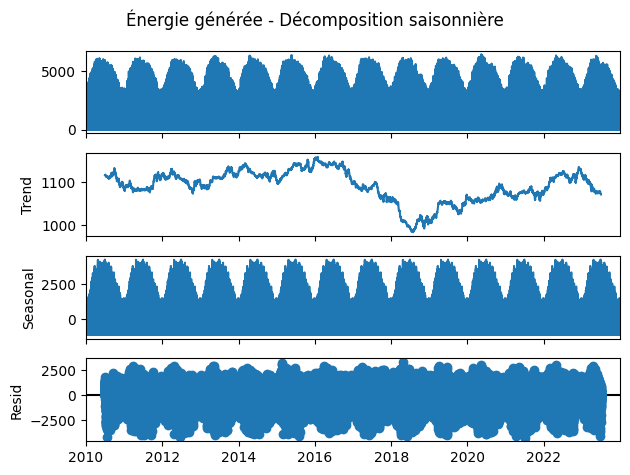

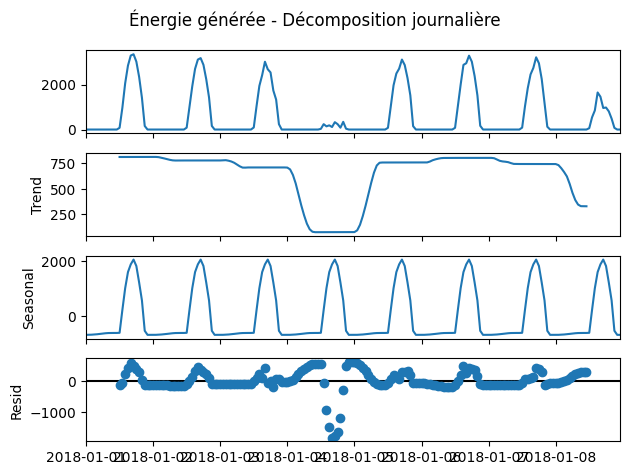

In [34]:
# Décomposer la série temporelle en composants saisonniers, tendance et résidus
result = seasonal_decompose(E_generated, model='additive', period=(24*365)) # Période annuelle
# Tracer les composants
result.plot()
plt.suptitle("Énergie générée - Décomposition saisonnière")
plt.tight_layout()
plt.show()


result = seasonal_decompose(E_generated['2018-01-01':'2018-01-08'], model='additive', period=24) # Période journalière

result.plot()
plt.suptitle("Énergie générée - Décomposition journalière")
plt.tight_layout()
plt.show()



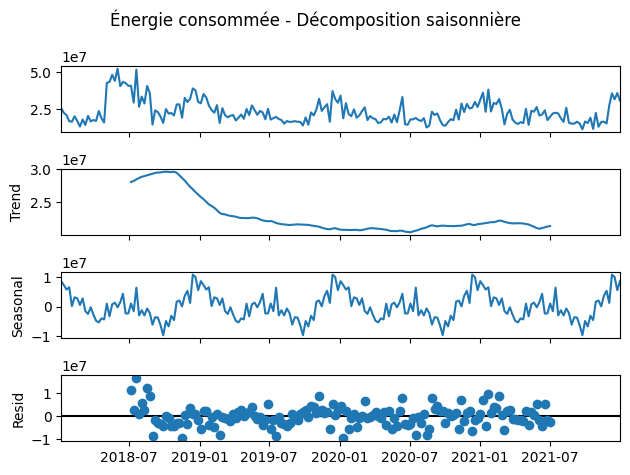

In [35]:
result = seasonal_decompose(E_consumed['2018':'2021'], model='additive', period=52) # Période annuelle (52 semaines dans une année)

result.plot()
plt.suptitle("Énergie consommée - Décomposition saisonnière")
plt.tight_layout()
plt.show()

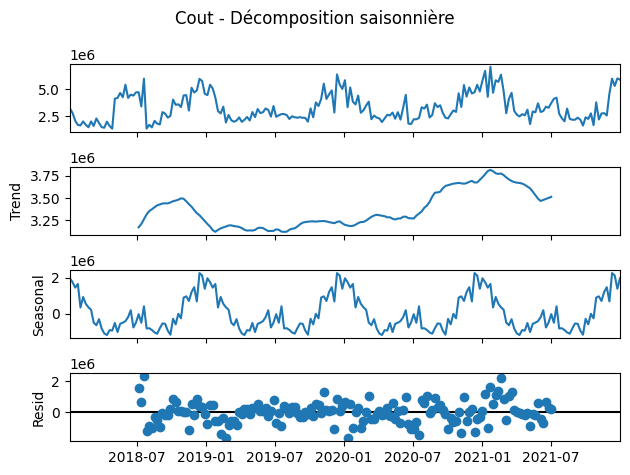

In [36]:
result = seasonal_decompose(e_cout['2018':'2021'], model='additive', period=52) # Période annuelle (52 semaines dans une année)

result.plot()
plt.suptitle("Cout - Décomposition saisonnière")
plt.tight_layout()
plt.show()

### Interpretation globale des resultat de decomposition:

- Le **cout** suit une tendance croissante, contrairement à **l'énergie consommée** et **générée**. .
- La composante saisonnière indique des fluctuations périodiques, suggérant une forte influence des saisons ou d’autres facteurs récurrents pour **les trois series**.
- Les résidus montrent qu’il y a des variations inexpliquées, peut-être dues à des événements exceptionnels (pannes, changements de politique énergétique, etc.).

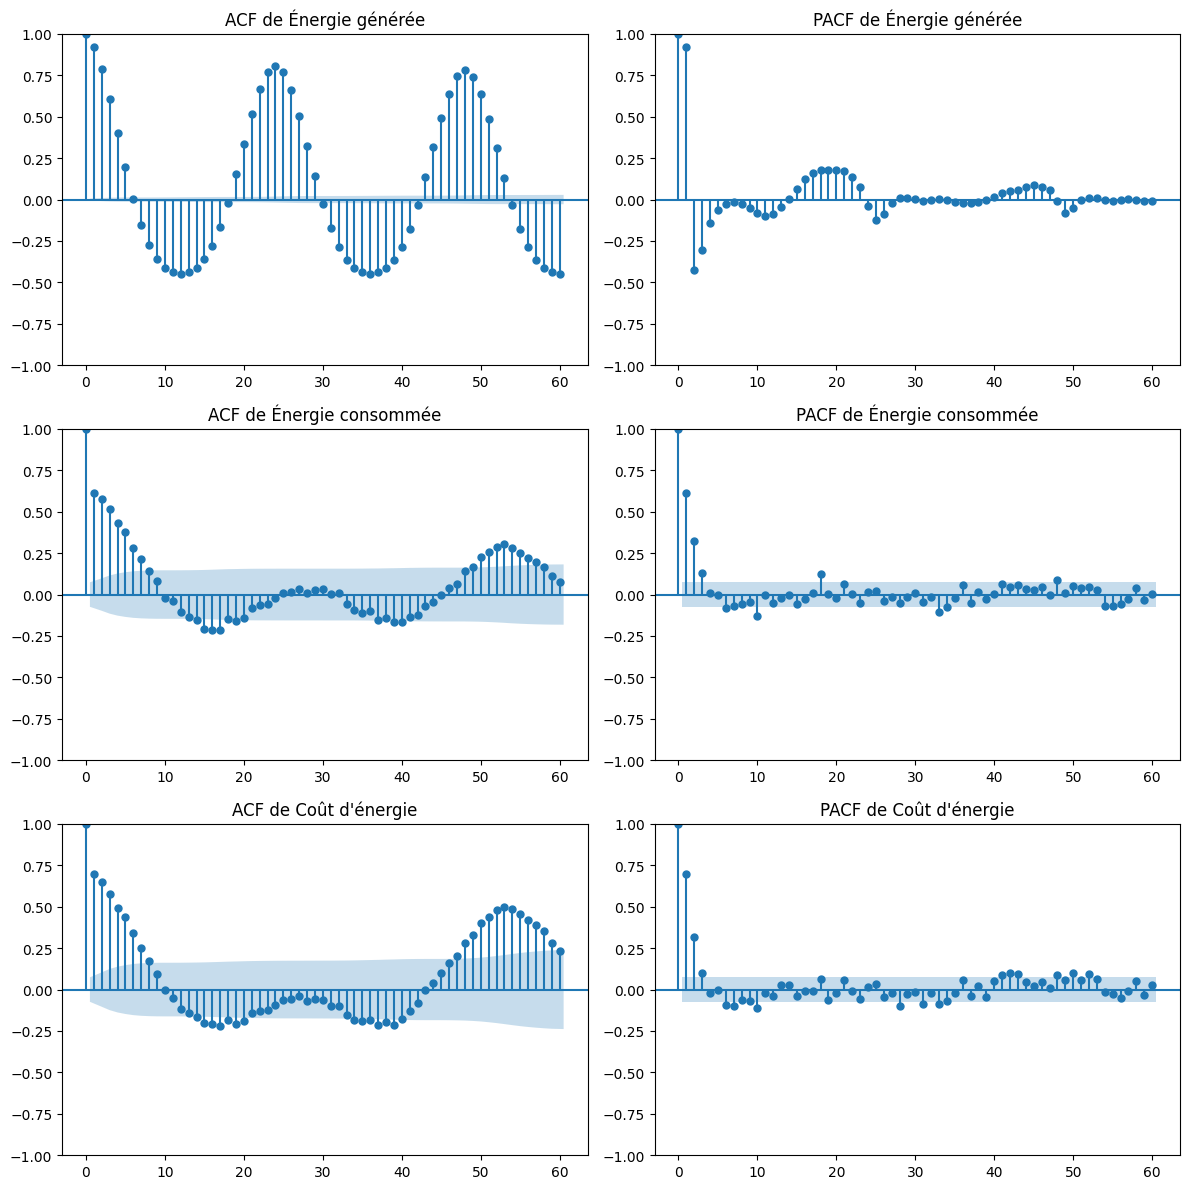

In [37]:
fig, axes = plt.subplots(len(series), 2, figsize=(12, 4 * len(series)))

for i, (name, data) in enumerate(series.items()):

    # Plot ACF
    sm.graphics.tsa.plot_acf(data, lags=60, ax=axes[i, 0])
    axes[i, 0].set_title(f"ACF de {name}")

    # Plot PACF
    sm.graphics.tsa.plot_pacf(data, lags=60, ax=axes[i, 1])
    axes[i, 1].set_title(f"PACF de {name}")

plt.tight_layout()
plt.show()

### Interpretation globale des resultat d'ACF/PACF :

- L'**ACF sinusoïdal** de l'**Énergie générée** suggère une **saisonnalité**.
- La **décroissance lente de l'ACF** pour l'**Énergie consommée** et le **Coût d'énergie** indique un processus **non stationnaire**.
- Le **seuil dans la PACF** suggère qu'un **modèle AR(p)** pourrait être approprié, où **p** est le nombre de retards significatifs dans la PACF. (p=2 pour E générée et p=1 pour les autres)
- Une **différenciation** pourrait être nécessaire pour rendre **stationnaires** l'énergie consommée et le coût de l'énergie.

### La Différenciation en Séries Temporelles

 **Qu'est-ce que la différenciation ? **

La **différenciation** est une technique utilisée en analyse des séries temporelles pour transformer une série **non stationnaire** en une série **stationnaire**. Elle consiste à **soustraire** la valeur précédente d'une observation actuelle.

Formellement, la première différence d'une série $ Y_t $ est donnée par :  
$$
Y'_t = Y_t - Y_{t-1}
$$
où $ Y'_t $ est la série différenciée.

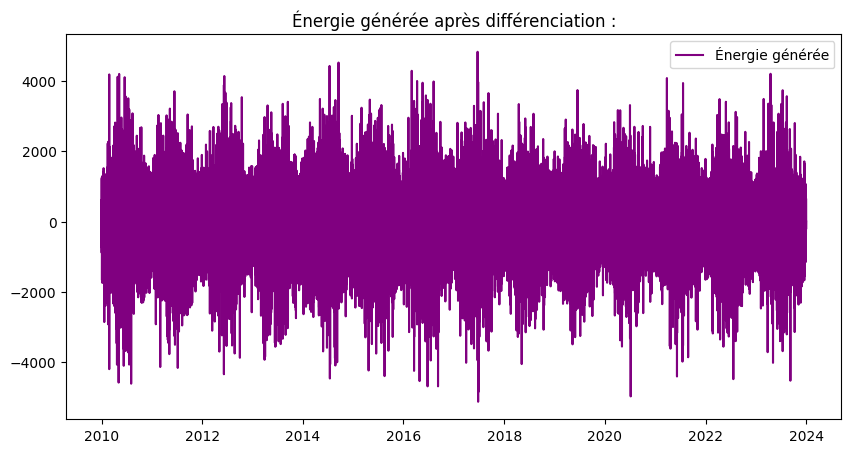

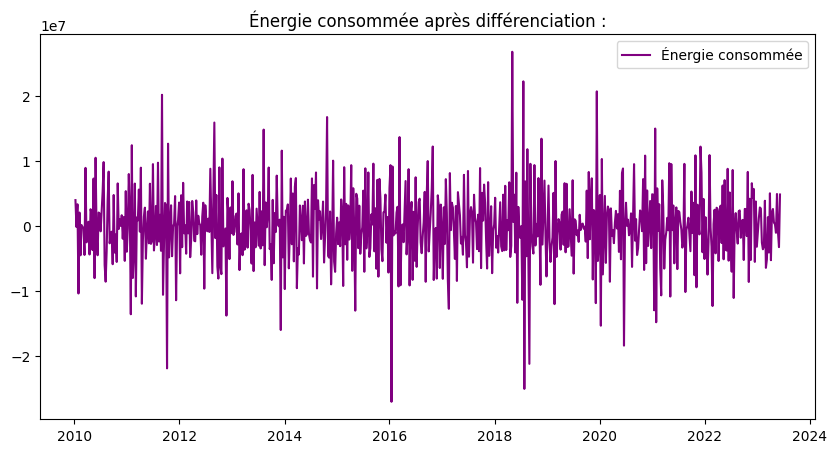

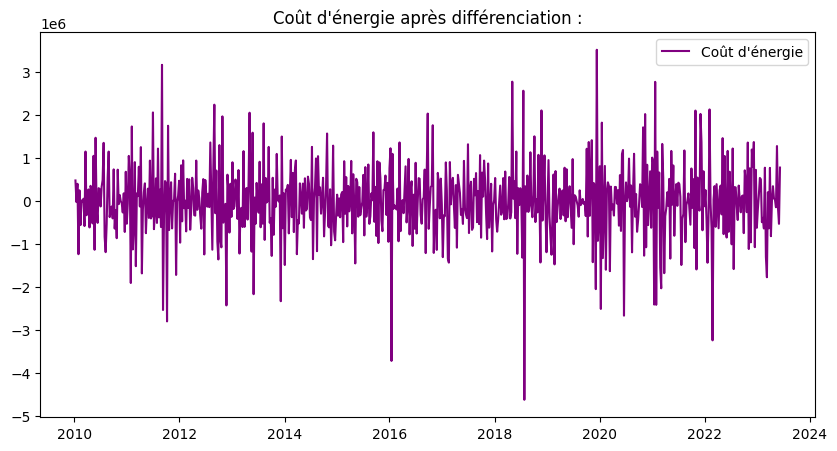

In [38]:
# Appliquer la différenciation à chaque série
differenced_series = {key: value.diff().dropna() for key, value in series.items()}

# Afficher un aperçu des séries différenciées
for name, data in differenced_series.items():
    # Tracer les estimations de la puissance AC au fil du temps
    plt.figure(figsize=(10, 5))
    plt.plot(data, label=name, color='Purple')  # Tracer la puissance AC estimée
    plt.title(f"{name} après différenciation :")  # Définir le titre du graphique
    plt.legend()  # Afficher la légende
    plt.show()

Après la différenciation, on peut distinguer visuellement que les séries sont clairement stationnaires, ce qui indique qu'elles ne l'étaient pas auparavant.

## SARIMA

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustement d'un modèle SARIMA
# Ici, on utilise un ordre saisonnier (1, 1, 0, 52) pour une saisonnalité hebdomadaire (52 semaines/an)
# L'ordre (1, 1, 0) correspond respectivement à l'ordre AR (autoregressive), I (intégration), MA (moyenne mobile)
model = SARIMAX(E_consumed, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52))  # Ajuster les paramètres si nécessaire

# Entraînement du modèle sur les données
result = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


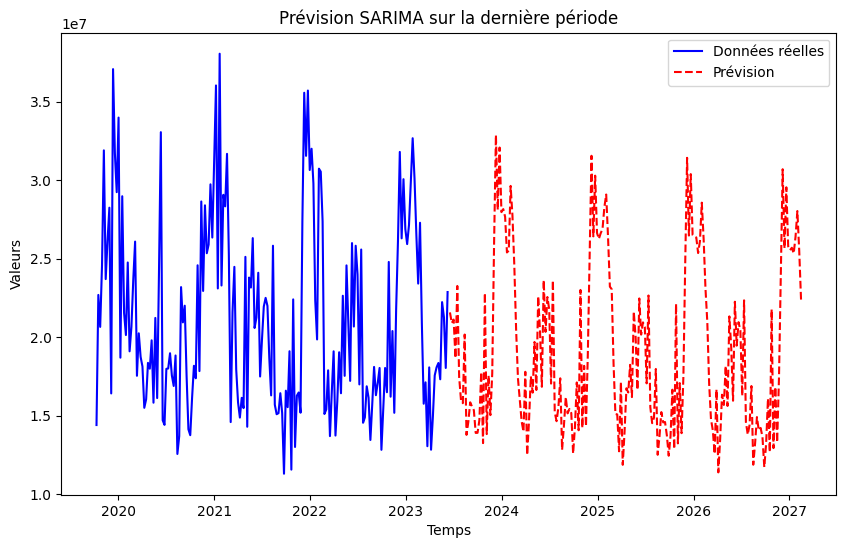

In [40]:
# Étape 3 : Prévoir les 10 prochaines périodes (ajustez le nombre de pas si nécessaire)
forecast_steps = 4 * 12 * 4  # Par exemple, l'ideal est la periode du serie 

# Génération des prévisions
forecast = result.forecast(steps=forecast_steps)  # Pas de paramètre alpha pour éviter les avertissements

# Création des indices temporels pour les prévisions
forecast_index = pd.date_range(start=E_consumed.index[-1], periods=forecast_steps + 1, freq='W')[1:]

# Affichage des données originales et des prévisions
plt.figure(figsize=(10, 6))

# Affichage des dernières données réelles (ex: dernier mois ou plus selon les pas)
plt.plot(E_consumed[-4*12*4:].index, E_consumed[-4*12*4:], label='Données réelles', color='blue')

# Affichage des prévisions
plt.plot(forecast_index, forecast, label='Prévision', color='red', linestyle='dashed')

plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.title('Prévision SARIMA sur la dernière période')
plt.legend()

plt.show()


# Deep learning

Pour le deep learning, nous allons essayer d’utiliser un modèle LSTM ainsi que des Transformers afin de prévoir les séries temporelles des jeux de données. Ces modèles sont particulièrement adaptés à la modélisation de données séquentielles et permettent de capturer des dépendances complexes dans le temps.

## Consumed Energy

Pour l’énergie consommée, les modèles de deep learning ne vont pas très bien performer en raison de la petite taille du jeu de données.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [42]:
data = E_consumed.values.reshape(-1, 1)  # S'assurer que les données ont la bonne forme (colonne unique)
scaler = StandardScaler()  # Initialisation du standardiseur (moyenne = 0, écart-type = 1)
scaled_data = scaler.fit_transform(data)  # Normalisation des données

In [43]:
def create_sequences(data, time_steps=24):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # Les time_steps précédents comme entrée
        Y.append(data[i+time_steps])    # La valeur suivante comme cible
    return np.array(X), np.array(Y)  # Conversion en tableaux NumPy

In [44]:
# Définir le nombre de pas de temps (52 semaines pour une saisonnalité annuelle)
time_steps = 52
X, Y = create_sequences(scaled_data, time_steps)

# Remodeler X pour qu'il soit compatible avec un LSTM (échantillons, pas de temps, caractéristiques)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [45]:
# Convertir les données en tenseurs (en supposant que X et Y sont ordonnés dans le temps)
X_tensor = torch.tensor(X, dtype=torch.float32)  # Caractéristiques
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Cibles

# Définir les indices de division (séquentiel, pas de mélange)
train_size = int(0.6 * len(X_tensor))  # Premier 60% pour l'entraînement
val_size = int(0.2 * len(X_tensor))    # Suivant 20% pour la validation
# Les 20% restants pour les tests

# Diviser les données de manière séquentielle
X_train, Y_train = X_tensor[:train_size], Y_tensor[:train_size]  # Entraînement
X_val, Y_val = X_tensor[train_size : train_size + val_size], Y_tensor[train_size : train_size + val_size]  # Validation
X_test, Y_test = X_tensor[train_size + val_size :], Y_tensor[train_size + val_size :]  # Test

# Créer des ensembles de données
train_dataset = TensorDataset(X_train, Y_train)  # Ensemble d'entraînement
val_dataset = TensorDataset(X_val, Y_val)  # Ensemble de validation
test_dataset = TensorDataset(X_test, Y_test)  # Ensemble de test

# DataLoaders (shuffle=False pour tous pour préserver l'ordre temporel)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Pas de mélange !
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Pas de mélange !
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Pas de mélange !

# Afficher le nombre d'échantillons dans chaque ensemble
print(f"Échantillons d'entraînement : {len(X_train)}, Échantillons de validation : {len(X_val)}, Échantillons de test : {len(X_test)}")

Échantillons d'entraînement : 390, Échantillons de validation : 130, Échantillons de test : 130


### Modèle LSTM

Ce modèle **LSTM** (Long Short-Term Memory) est conçu pour traiter des séries temporelles. Voici les principales caractéristiques :

- **LSTM** : Il est utilisé pour apprendre des dépendances à long terme dans les séquences de données. Il prend en compte les valeurs passées pour - prévoir les valeurs futures.

- **Dropout** : Appliqué au LSTM et avant la couche finale pour éviter le surapprentissage (overfitting).

- **Couche fully connected (FC) :** Cette couche dense prend la sortie du LSTM pour produire une prédiction finale. Elle est utilisée pour réduire la dimensionnalité et fournir la sortie attendue.

- **Activation ReLU :** Une fonction d'activation qui introduit de la non-linéarité dans le modèle.

Le modèle est structuré pour accepter des données séquentielles, et il peut être adapté à divers problèmes de prévision, comme les séries temporelles.

In [46]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2, weight_decay=1e-5):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Ajouter du dropout au LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)

        # Ajouter du dropout avant la couche finale
        self.dropout = nn.Dropout(dropout)

        # Couche fully connected (dense) pour la sortie
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        # Initialiser l'état caché avec des zéros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Passer les données à travers le LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Appliquer le dropout avant la couche finale
        out = self.dropout(out[:, -1, :])
        out = F.relu(out)  # Appliquer la fonction ReLU
        out = self.fc(out)    # Passer par la couche fully connected
        return out

# Créer le modèle
model = LSTM(1, 128, 2, dropout=0.2).to(device)

In [47]:
# Premièrement, ajoutez ces variables au début de votre script (en dehors des fonctions)
# Variables globales pour stocker les pertes
train_losses = []
val_losses = []
test_losses = []
best_val_loss = float('inf')

def train_one_epoch(epoch):
    model.train()
    epoch_loss = 0.0

    # Barre principale pour l'entraînement
    with tqdm(train_loader, unit="batch", leave=False,
              desc=f"Epoch {epoch+1}/{num_epochs} [Train]") as pbar:
        for x_batch, y_batch in pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward + backward
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # MàJ des métriques
            batch_loss = loss.item()
            epoch_loss += batch_loss
            avg_loss = epoch_loss / (pbar.n + 1)

            # Affichage dans la barre
            pbar.set_postfix({
                "loss": f"{batch_loss:.4f}",
                "avg": f"{avg_loss:.4f}"
            })

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    tqdm.write(f"[Train] Epoch {epoch+1} – avg loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss


def validate_one_epoch(epoch):
    global best_val_loss
    model.eval()
    running_loss = 0.0
    all_targets, all_preds = [], []

    # Barre principale pour la validation
    with tqdm(val_loader, unit="batch", leave=False,
              desc=f"Epoch {epoch+1}/{num_epochs} [Val]") as pbar:
        for x_batch, y_batch in pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            with torch.no_grad():
                outputs = model(x_batch)
                loss = loss_function(outputs, y_batch)

            # Collecte pour métriques finales
            all_targets.append(y_batch.cpu().numpy())
            all_preds.append(outputs.cpu().numpy())

            batch_loss = loss.item()
            running_loss += batch_loss
            avg_loss = running_loss / (pbar.n + 1)
            pbar.set_postfix({"loss": f"{avg_loss:.4f}"})

    avg_val_loss = running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    targets = np.concatenate(all_targets)
    preds = np.concatenate(all_preds)
    val_mae = np.mean(np.abs(preds - targets))
    val_rmse = np.sqrt(np.mean((preds - targets)**2))

    # Sauvegarde du meilleur modèle
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'val_loss': best_val_loss,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
        }, 'best_model.pth')
        tqdm.write(
            f"[Val] Epoch {epoch+1} – Nouvelle meilleure performance ! "
            f"loss={avg_val_loss:.4f}, MAE={val_mae:.4f}, RMSE={val_rmse:.4f}"
        )
    else:
        tqdm.write(
            f"[Val] Epoch {epoch+1} – loss={avg_val_loss:.4f} "
            f"(best={best_val_loss:.4f}), MAE={val_mae:.4f}, RMSE={val_rmse:.4f}"
        )
    return avg_val_loss


def train_and_validate():
    for epoch in range(num_epochs):
        train_one_epoch(epoch)
        validate_one_epoch(epoch)

def test_model():
    """Final evaluation on test set using best model"""
    # Load best model
    model.load_state_dict(torch.load('best_model.pth', weights_only=True)['model_state_dict'])
    model.eval()
    
    test_loss = 0.0
    all_preds = []
    all_targets = []

    # Inference with progress bar
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader, desc="Testing", unit="batch"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            
            loss = loss_function(outputs, y_batch)
            test_loss += loss.item()
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    # Calculate metrics
    avg_loss = test_loss / len(test_loader)
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    
    metrics = {
        'loss': avg_loss,
        'mae': np.mean(np.abs(preds - targets)),
        'rmse': np.sqrt(np.mean((preds - targets)**2)),
        'R2': 1 - np.sum((targets - preds) ** 2) / np.sum((targets - np.mean(targets)) ** 2)
    }


    # Print results
    print("\n" + "="*40)
    print("FINAL TEST RESULTS")
    print("="*40)
    print(f"{'Loss:':<10}{metrics['loss']:.4f}")
    print(f"{'MAE:':<10}{metrics['mae']:.4f}")
    print(f"{'RMSE:':<10}{metrics['rmse']:.4f}")
    print(f"{'R²:':<10}{metrics['R2']:.4f}")
    print("="*40)

    # Plot last 100 points
    plt.figure(figsize=(12,5))
    plt.plot(targets[-100:], label='True', alpha=0.7)
    plt.plot(preds[-100:], label='Predicted', linestyle='--')
    plt.title("Test Predictions (Last 100 Points)")
    plt.legend()
    plt.show()

    return metrics

def plot_losses():
    """
    Tracer les pertes d'entraînement et de validation.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

def reset_losses():
    train_losses.clear()
    val_losses.clear()
    test_losses.clear()

In [48]:
reset_losses()

model = LSTM(1, 128, 2, dropout=0.3).to(device)
learning_rate = 0.0005
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses = []
val_losses = []
test_losses = []

best_val_loss = float('inf')
train_and_validate()

print("\nTraining completed!")

[Train] Epoch 1 – avg loss: 1.6845


[Val] Epoch 1 – Nouvelle meilleure performance ! loss=0.9199, MAE=0.7998, RMSE=1.0383


[Train] Epoch 2 – avg loss: 1.6074


[Val] Epoch 2 – Nouvelle meilleure performance ! loss=0.8408, MAE=0.7694, RMSE=0.9922


[Train] Epoch 3 – avg loss: 1.4439


[Val] Epoch 3 – Nouvelle meilleure performance ! loss=0.6883, MAE=0.7112, RMSE=0.8943


[Train] Epoch 4 – avg loss: 1.2139


[Val] Epoch 4 – Nouvelle meilleure performance ! loss=0.5414, MAE=0.6354, RMSE=0.8109


[Train] Epoch 5 – avg loss: 1.0081


[Val] Epoch 5 – Nouvelle meilleure performance ! loss=0.4966, MAE=0.5887, RMSE=0.7815


[Train] Epoch 6 – avg loss: 0.9690


[Val] Epoch 6 – Nouvelle meilleure performance ! loss=0.4859, MAE=0.5946, RMSE=0.7718


[Train] Epoch 7 – avg loss: 0.9052


[Val] Epoch 7 – Nouvelle meilleure performance ! loss=0.4783, MAE=0.5704, RMSE=0.7629


[Train] Epoch 8 – avg loss: 0.8409


[Val] Epoch 8 – loss=0.5152 (best=0.4783), MAE=0.5930, RMSE=0.7782


[Train] Epoch 9 – avg loss: 0.7749


[Val] Epoch 9 – loss=0.5071 (best=0.4783), MAE=0.5727, RMSE=0.7778


[Train] Epoch 10 – avg loss: 0.8212


[Val] Epoch 10 – loss=0.5919 (best=0.4783), MAE=0.6044, RMSE=0.8084


[Train] Epoch 11 – avg loss: 0.7995


[Val] Epoch 11 – loss=0.5508 (best=0.4783), MAE=0.5808, RMSE=0.7922


[Train] Epoch 12 – avg loss: 0.7634


[Val] Epoch 12 – loss=0.5943 (best=0.4783), MAE=0.5991, RMSE=0.8235


[Train] Epoch 13 – avg loss: 0.8071


[Val] Epoch 13 – loss=0.6045 (best=0.4783), MAE=0.6135, RMSE=0.8348


[Train] Epoch 14 – avg loss: 0.8171


[Val] Epoch 14 – loss=0.6434 (best=0.4783), MAE=0.6169, RMSE=0.8437


[Train] Epoch 15 – avg loss: 0.7571


[Val] Epoch 15 – loss=0.6356 (best=0.4783), MAE=0.6105, RMSE=0.8382


[Train] Epoch 16 – avg loss: 0.7567


[Val] Epoch 16 – loss=0.6668 (best=0.4783), MAE=0.6213, RMSE=0.8517


[Train] Epoch 17 – avg loss: 0.7042


[Val] Epoch 17 – loss=0.6885 (best=0.4783), MAE=0.6315, RMSE=0.8654


[Train] Epoch 18 – avg loss: 0.7124


[Val] Epoch 18 – loss=0.6625 (best=0.4783), MAE=0.6360, RMSE=0.8603


[Train] Epoch 19 – avg loss: 0.7107


[Val] Epoch 19 – loss=0.7210 (best=0.4783), MAE=0.6397, RMSE=0.8725


[Train] Epoch 20 – avg loss: 0.6903


[Val] Epoch 20 – loss=0.6882 (best=0.4783), MAE=0.6367, RMSE=0.8806


[Train] Epoch 21 – avg loss: 0.7045


[Val] Epoch 21 – loss=0.7128 (best=0.4783), MAE=0.6367, RMSE=0.8722


[Train] Epoch 22 – avg loss: 0.6777


[Val] Epoch 22 – loss=0.6103 (best=0.4783), MAE=0.6168, RMSE=0.8474


[Train] Epoch 23 – avg loss: 0.7763


[Val] Epoch 23 – loss=0.7478 (best=0.4783), MAE=0.6583, RMSE=0.9007


[Train] Epoch 24 – avg loss: 0.7179


[Val] Epoch 24 – loss=0.6972 (best=0.4783), MAE=0.6412, RMSE=0.8840


[Train] Epoch 25 – avg loss: 0.6783


[Val] Epoch 25 – loss=0.6837 (best=0.4783), MAE=0.6358, RMSE=0.8704


[Train] Epoch 26 – avg loss: 0.6779


[Val] Epoch 26 – loss=0.7317 (best=0.4783), MAE=0.6496, RMSE=0.8885


[Train] Epoch 27 – avg loss: 0.6463


[Val] Epoch 27 – loss=0.7479 (best=0.4783), MAE=0.6598, RMSE=0.9101


[Train] Epoch 28 – avg loss: 0.6771


[Val] Epoch 28 – loss=0.7779 (best=0.4783), MAE=0.6644, RMSE=0.9089


[Train] Epoch 29 – avg loss: 0.6546


[Val] Epoch 29 – loss=0.7591 (best=0.4783), MAE=0.6617, RMSE=0.8996


[Train] Epoch 30 – avg loss: 0.6160


[Val] Epoch 30 – loss=0.7747 (best=0.4783), MAE=0.6711, RMSE=0.9158


[Train] Epoch 31 – avg loss: 0.5995


[Val] Epoch 31 – loss=0.8260 (best=0.4783), MAE=0.6925, RMSE=0.9348


[Train] Epoch 32 – avg loss: 0.6082


[Val] Epoch 32 – loss=0.8952 (best=0.4783), MAE=0.7124, RMSE=0.9566


[Train] Epoch 33 – avg loss: 0.6092


[Val] Epoch 33 – loss=0.8883 (best=0.4783), MAE=0.7238, RMSE=0.9702


[Train] Epoch 34 – avg loss: 0.6172


[Val] Epoch 34 – loss=0.7755 (best=0.4783), MAE=0.6896, RMSE=0.9344


[Train] Epoch 35 – avg loss: 0.6214


[Val] Epoch 35 – loss=0.7472 (best=0.4783), MAE=0.6735, RMSE=0.9053


[Train] Epoch 36 – avg loss: 0.6095


[Val] Epoch 36 – loss=0.8167 (best=0.4783), MAE=0.6891, RMSE=0.9382


[Train] Epoch 37 – avg loss: 0.6618


[Val] Epoch 37 – loss=0.8004 (best=0.4783), MAE=0.6850, RMSE=0.9353


[Train] Epoch 38 – avg loss: 0.5752


[Val] Epoch 38 – loss=0.8781 (best=0.4783), MAE=0.7084, RMSE=0.9635


[Train] Epoch 39 – avg loss: 0.5583


[Val] Epoch 39 – loss=0.8970 (best=0.4783), MAE=0.7153, RMSE=0.9646


[Train] Epoch 40 – avg loss: 0.6403


[Val] Epoch 40 – loss=0.7653 (best=0.4783), MAE=0.6763, RMSE=0.9212


[Train] Epoch 41 – avg loss: 0.6104


[Val] Epoch 41 – loss=0.7877 (best=0.4783), MAE=0.6853, RMSE=0.9383


[Train] Epoch 42 – avg loss: 0.6393


[Val] Epoch 42 – loss=0.8161 (best=0.4783), MAE=0.6899, RMSE=0.9436


[Train] Epoch 43 – avg loss: 0.6409


[Val] Epoch 43 – loss=0.8372 (best=0.4783), MAE=0.6928, RMSE=0.9342


[Train] Epoch 44 – avg loss: 0.5682


[Val] Epoch 44 – loss=0.7984 (best=0.4783), MAE=0.6958, RMSE=0.9306


[Train] Epoch 45 – avg loss: 0.6137


[Val] Epoch 45 – loss=0.8638 (best=0.4783), MAE=0.7188, RMSE=0.9732


[Train] Epoch 46 – avg loss: 0.6268


[Val] Epoch 46 – loss=0.7878 (best=0.4783), MAE=0.6963, RMSE=0.9363


[Train] Epoch 47 – avg loss: 0.5695


[Val] Epoch 47 – loss=0.8755 (best=0.4783), MAE=0.7214, RMSE=0.9796


[Train] Epoch 48 – avg loss: 0.5323


[Val] Epoch 48 – loss=0.9698 (best=0.4783), MAE=0.7546, RMSE=1.0232


[Train] Epoch 49 – avg loss: 0.5115


[Val] Epoch 49 – loss=0.9199 (best=0.4783), MAE=0.7364, RMSE=0.9983


[Train] Epoch 50 – avg loss: 0.6093


[Val] Epoch 50 – loss=0.8723 (best=0.4783), MAE=0.7160, RMSE=0.9747


[Train] Epoch 51 – avg loss: 0.6137


[Val] Epoch 51 – loss=0.8811 (best=0.4783), MAE=0.7216, RMSE=0.9786


[Train] Epoch 52 – avg loss: 0.5264


[Val] Epoch 52 – loss=0.7410 (best=0.4783), MAE=0.6788, RMSE=0.9020


[Train] Epoch 53 – avg loss: 0.6975


[Val] Epoch 53 – loss=0.8145 (best=0.4783), MAE=0.6795, RMSE=0.9250


[Train] Epoch 54 – avg loss: 0.5795


[Val] Epoch 54 – loss=0.8034 (best=0.4783), MAE=0.6879, RMSE=0.9308


[Train] Epoch 55 – avg loss: 0.5980


[Val] Epoch 55 – loss=0.8464 (best=0.4783), MAE=0.7058, RMSE=0.9543


[Train] Epoch 56 – avg loss: 0.5401


[Val] Epoch 56 – loss=0.9106 (best=0.4783), MAE=0.7141, RMSE=0.9625


[Train] Epoch 57 – avg loss: 0.5464


[Val] Epoch 57 – loss=0.8675 (best=0.4783), MAE=0.7183, RMSE=0.9717


[Train] Epoch 58 – avg loss: 0.5395


[Val] Epoch 58 – loss=0.8505 (best=0.4783), MAE=0.7254, RMSE=0.9799


[Train] Epoch 59 – avg loss: 0.5817


[Val] Epoch 59 – loss=0.7818 (best=0.4783), MAE=0.6884, RMSE=0.9347


[Train] Epoch 60 – avg loss: 0.5298


[Val] Epoch 60 – loss=0.8308 (best=0.4783), MAE=0.7044, RMSE=0.9504


[Train] Epoch 61 – avg loss: 0.5106


[Val] Epoch 61 – loss=0.9553 (best=0.4783), MAE=0.7503, RMSE=1.0181


[Train] Epoch 62 – avg loss: 0.5208


[Val] Epoch 62 – loss=0.8685 (best=0.4783), MAE=0.7133, RMSE=0.9612


[Train] Epoch 63 – avg loss: 0.5056


[Val] Epoch 63 – loss=0.9097 (best=0.4783), MAE=0.7219, RMSE=0.9774


[Train] Epoch 64 – avg loss: 0.5280


[Val] Epoch 64 – loss=0.9386 (best=0.4783), MAE=0.7497, RMSE=1.0125


[Train] Epoch 65 – avg loss: 0.5326


[Val] Epoch 65 – loss=1.0118 (best=0.4783), MAE=0.7716, RMSE=1.0440


[Train] Epoch 66 – avg loss: 0.5299


[Val] Epoch 66 – loss=0.9077 (best=0.4783), MAE=0.7330, RMSE=0.9874


[Train] Epoch 67 – avg loss: 0.4841


[Val] Epoch 67 – loss=0.9335 (best=0.4783), MAE=0.7314, RMSE=0.9913


[Train] Epoch 68 – avg loss: 0.4875


[Val] Epoch 68 – loss=0.9353 (best=0.4783), MAE=0.7386, RMSE=1.0047


[Train] Epoch 69 – avg loss: 0.5278


[Val] Epoch 69 – loss=0.8389 (best=0.4783), MAE=0.7231, RMSE=0.9803


[Train] Epoch 70 – avg loss: 0.5594


[Val] Epoch 70 – loss=0.9528 (best=0.4783), MAE=0.7173, RMSE=0.9692


[Train] Epoch 71 – avg loss: 0.5810


[Val] Epoch 71 – loss=0.8854 (best=0.4783), MAE=0.7087, RMSE=0.9543


[Train] Epoch 72 – avg loss: 0.4891


[Val] Epoch 72 – loss=0.8828 (best=0.4783), MAE=0.7256, RMSE=0.9708


[Train] Epoch 73 – avg loss: 0.4954


[Val] Epoch 73 – loss=1.0086 (best=0.4783), MAE=0.7710, RMSE=1.0463


[Train] Epoch 74 – avg loss: 0.4359


[Val] Epoch 74 – loss=1.0186 (best=0.4783), MAE=0.7817, RMSE=1.0537


[Train] Epoch 75 – avg loss: 0.4676


[Val] Epoch 75 – loss=0.9521 (best=0.4783), MAE=0.7478, RMSE=1.0085


[Train] Epoch 76 – avg loss: 0.5533


[Val] Epoch 76 – loss=1.0236 (best=0.4783), MAE=0.7828, RMSE=1.0528


[Train] Epoch 77 – avg loss: 0.5472


[Val] Epoch 77 – loss=0.7697 (best=0.4783), MAE=0.6955, RMSE=0.9322


[Train] Epoch 78 – avg loss: 0.5216


[Val] Epoch 78 – loss=0.7700 (best=0.4783), MAE=0.7095, RMSE=0.9530


[Train] Epoch 79 – avg loss: 0.4951


[Val] Epoch 79 – loss=1.0066 (best=0.4783), MAE=0.7833, RMSE=1.0333


[Train] Epoch 80 – avg loss: 0.4972


[Val] Epoch 80 – loss=0.9615 (best=0.4783), MAE=0.7474, RMSE=0.9981


[Train] Epoch 81 – avg loss: 0.5464


[Val] Epoch 81 – loss=0.8165 (best=0.4783), MAE=0.7100, RMSE=0.9659


[Train] Epoch 82 – avg loss: 0.4357


[Val] Epoch 82 – loss=0.9574 (best=0.4783), MAE=0.7543, RMSE=1.0222


[Train] Epoch 83 – avg loss: 0.4411


[Val] Epoch 83 – loss=1.0067 (best=0.4783), MAE=0.7860, RMSE=1.0616


[Train] Epoch 84 – avg loss: 0.4240


[Val] Epoch 84 – loss=0.9819 (best=0.4783), MAE=0.7798, RMSE=1.0532


[Train] Epoch 85 – avg loss: 0.4470


[Val] Epoch 85 – loss=0.8441 (best=0.4783), MAE=0.7247, RMSE=0.9882


[Train] Epoch 86 – avg loss: 0.4272


[Val] Epoch 86 – loss=1.0271 (best=0.4783), MAE=0.7563, RMSE=1.0283


[Train] Epoch 87 – avg loss: 0.4340


[Val] Epoch 87 – loss=0.9194 (best=0.4783), MAE=0.7595, RMSE=1.0277


[Train] Epoch 88 – avg loss: 0.4121


[Val] Epoch 88 – loss=1.0465 (best=0.4783), MAE=0.7824, RMSE=1.0605


[Train] Epoch 89 – avg loss: 0.4165


[Val] Epoch 89 – loss=0.9896 (best=0.4783), MAE=0.7538, RMSE=1.0305


[Train] Epoch 90 – avg loss: 0.4235


[Val] Epoch 90 – loss=1.0107 (best=0.4783), MAE=0.7739, RMSE=1.0449


[Train] Epoch 91 – avg loss: 0.4191


[Val] Epoch 91 – loss=0.9531 (best=0.4783), MAE=0.7599, RMSE=1.0113


[Train] Epoch 92 – avg loss: 0.3987


[Val] Epoch 92 – loss=1.0359 (best=0.4783), MAE=0.7875, RMSE=1.0688


[Train] Epoch 93 – avg loss: 0.4100


[Val] Epoch 93 – loss=1.0257 (best=0.4783), MAE=0.7905, RMSE=1.0786


[Train] Epoch 94 – avg loss: 0.3907


[Val] Epoch 94 – loss=0.9224 (best=0.4783), MAE=0.7666, RMSE=1.0444


[Train] Epoch 95 – avg loss: 0.4147


[Val] Epoch 95 – loss=0.9895 (best=0.4783), MAE=0.7736, RMSE=1.0499


[Train] Epoch 96 – avg loss: 0.4018


[Val] Epoch 96 – loss=1.0762 (best=0.4783), MAE=0.8070, RMSE=1.1073


[Train] Epoch 97 – avg loss: 0.4155


[Val] Epoch 97 – loss=0.9670 (best=0.4783), MAE=0.7770, RMSE=1.0565


[Train] Epoch 98 – avg loss: 0.4096


[Val] Epoch 98 – loss=1.0639 (best=0.4783), MAE=0.7985, RMSE=1.0681


[Train] Epoch 99 – avg loss: 0.4429


[Val] Epoch 99 – loss=1.1045 (best=0.4783), MAE=0.8202, RMSE=1.1249


[Train] Epoch 100 – avg loss: 0.4576


[Val] Epoch 100 – loss=0.8604 (best=0.4783), MAE=0.7434, RMSE=0.9996

Training completed!


Running final evaluation...


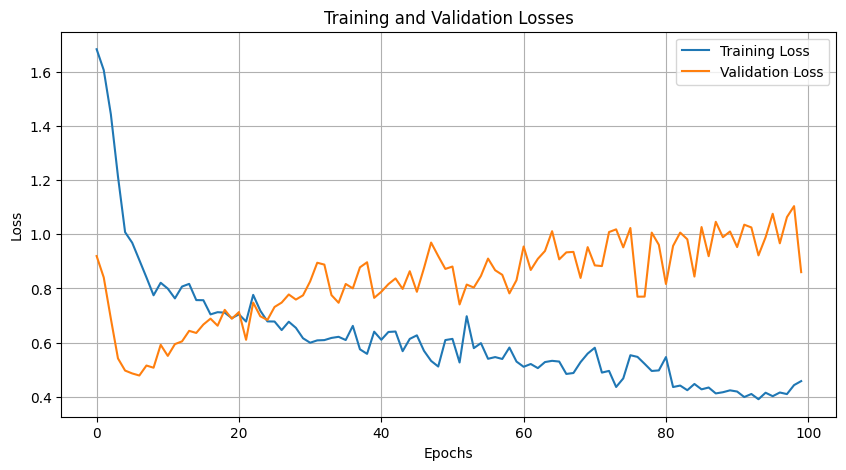

/tmp/ipykernel_31/3105391348.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
Testing: 100%|████


FINAL TEST RESULTS
Loss:     0.3970
MAE:      0.5409
RMSE:     0.6823
R²:       0.4364


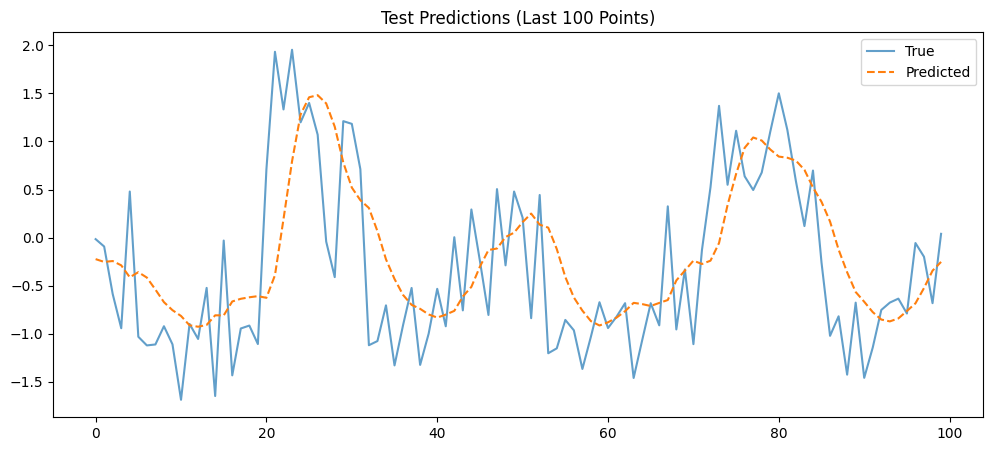

In [49]:
print("Running final evaluation...")
# 1. Tracer les courbes d'apprentissage
plot_losses()

# 2. Évaluation finale sur le test set
test_results = test_model()

In [50]:
with torch.no_grad():

    predicted = model(X_train.to(device)).to('cpu').numpy()

train_predictions_normalized = predicted.flatten()
train_predictions = scaler.inverse_transform(train_predictions_normalized.reshape(-1, 1))

Y_train_unnormalized= scaler.inverse_transform(Y_train.reshape(-1, 1))

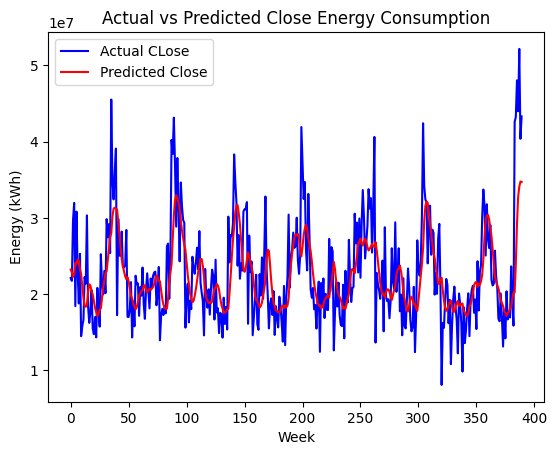

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [51]:
plt.plot(Y_train_unnormalized, label='Actual CLose', color='blue')
plt.plot(train_predictions, label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Energy Consumption')
plt.xlabel('Week')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()
# Plot the predicted values
plt.figure(figsize=(10, 5))

In [52]:
# Get predictions from the model
test_predictions_tensor = model(X_test.to(device)).detach().cpu()

# Convert the tensor to a NumPy array
test_predictions_normalized = test_predictions_tensor.numpy().flatten()

# Inverse transform the scaled predictions
test_predictions = scaler.inverse_transform(test_predictions_normalized.reshape(-1, 1))

Y_test_unnormalized = scaler.inverse_transform(Y_test.reshape(-1, 1))

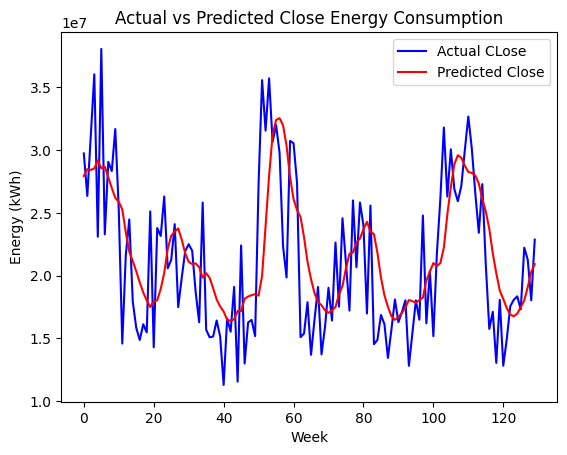

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [53]:
plt.plot(Y_test_unnormalized, label='Actual CLose', color='blue')
plt.plot(test_predictions, label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Energy Consumption')
plt.xlabel('Week')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()
# Plot the predicted values
plt.figure(figsize=(10, 5))

In [54]:
def predict_and_plot_future(
    model,
    series,
    window_size,
    future_steps,
    scaler=None,
    device='cpu',
    datetime_col=None,
    freq='D',  # Change this to 'H', 'M', 'MS', '30min', etc. depending on your time series
    title='Forecast'
):
    """
    Predict and plot future time steps using an LSTM model.

    Args:
        model: Trained PyTorch LSTM model.
        series: 1D pandas Series or array of the full historical time series.
        window_size: Size of the input window.
        future_steps: Number of future steps to predict.
        scaler: Scaler used during training (optional).
        device: Device to run the model on.
        datetime_col: Optional datetime index if using pandas Series with a time index.
        freq: Frequency of the time series (used to extend the index).
        title: Title for the plot.
    """
    model.eval()

    # Use the last window for rolling prediction
    history = list(series[-window_size:])
    predictions = []

    for _ in range(future_steps):
        input_seq = np.array(history[-window_size:]).reshape(1, window_size, 1)

        if scaler:
            input_seq = scaler.transform(input_seq.reshape(-1, 1)).reshape(1, window_size, 1)

        input_tensor = torch.tensor(input_seq, dtype=torch.float32).to(device)

        with torch.no_grad():
            pred = model(input_tensor).cpu().item()

        if scaler:
            pred = scaler.inverse_transform([[pred]])[0][0]

        predictions.append(pred)
        history.append(pred)

    # Handle historical and future time indices
    if isinstance(series, pd.Series) and isinstance(series.index, pd.DatetimeIndex):
        historical_index = series.index

        # Try to infer frequency if it's not set
        freq_inferred = series.index.freq or pd.infer_freq(series.index)
        if freq_inferred is None:
            raise ValueError("Could not infer frequency from the time index. Please pass `freq='W'` manually.")

        future_index = pd.date_range(
            start=historical_index[-1] + pd.tseries.frequencies.to_offset(freq_inferred),
            periods=future_steps,
            freq=freq_inferred
        )
    else:
        # No datetime index, use fallback
        start = pd.to_datetime('2023-01-01') if datetime_col is None else pd.to_datetime(datetime_col)
        historical_index = pd.date_range(start=start, periods=len(series), freq=freq)
        future_index = pd.date_range(start=historical_index[-1] + pd.tseries.frequencies.to_offset(freq), periods=future_steps, freq=freq)


    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(historical_index[-52*4:], series[-52*4:], label='Historical', linewidth=2)
    plt.plot(future_index, predictions, label='Forecast', linewidth=2, linestyle='--', color='orange')
    plt.axvline(x=historical_index[-1], color='gray', linestyle=':', label='Forecast Start')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return predictions


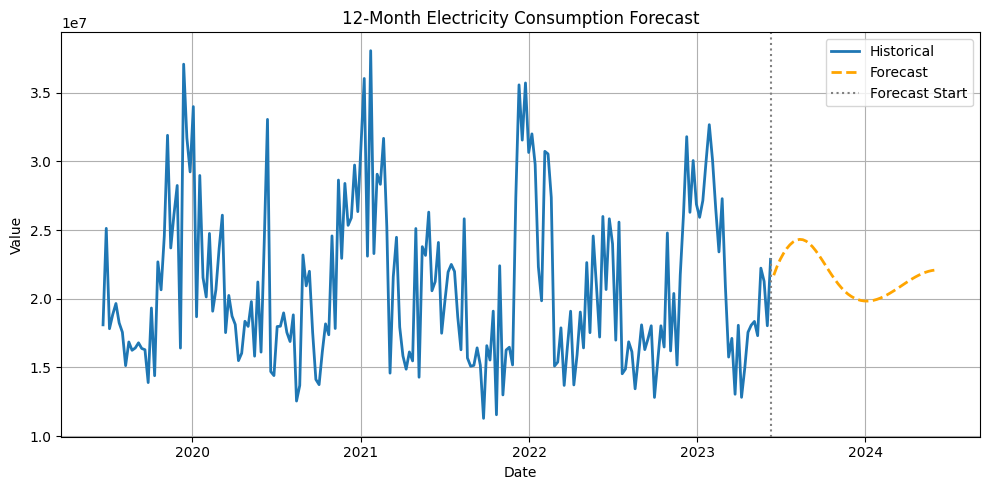

[21712106.808582492,
 22348152.188168462,
 22865848.07766954,
 23295102.99758561,
 23648321.59159797,
 23928509.970721338,
 24135945.125399698,
 24268512.691911988,
 24323688.268716432,
 24299979.845936872,
 24199104.344492033,
 24026616.767251942,
 23790512.851720553,
 23501518.555537663,
 23172468.10247587,
 22817122.274832793,
 22449082.3554917,
 22080934.02902809,
 21723336.067155328,
 21384731.892807595,
 21071363.137277756,
 20792688.659372024,
 20547993.0420541,
 20340788.596125185,
 20175591.935161877,
 20043417.813033387,
 19944096.496872924,
 19876642.176590797,
 19839295.74795274,
 19829957.441465348,
 19847011.89604067,
 19888369.33823164,
 19954755.680923194,
 20041908.60995753,
 20147411.081330523,
 20268224.696797784,
 20401685.909852542,
 20545342.69032849,
 20694140.43743521,
 20849481.796394613,
 21007940.32244353,
 21164520.791306783,
 21317132.42993266,
 21462197.553376935,
 21597528.526898902,
 21720459.504901122,
 21828650.362956036,
 21922571.914846085,
 21997787

In [56]:
# Assume you have a trained model, and last known sequence
last_known = E_consumed.values  # Replace with your actual series
future_steps = 52

# Example with a pandas Series that has a DateTimeIndex
predict_and_plot_future(
    model=model,
    series=E_consumed,     # Replace with your series
    window_size=time_steps,
    future_steps=future_steps,
    scaler=scaler,                    # Pass if you used MinMaxScaler or similar
    device=device,
    freq='W',
    title='12-Month Electricity Consumption Forecast'
)

## Generated Energy

En raison de la taille très importante des données (130k points~), nous allons d'abord en utiliser une portion pour trouver un bon modèle, puis nous l'entraînerons sur l'ensemble des données par la suite.

In [58]:
E_generated_portion = E_generated['2022':'2023']
print(E_generated_portion)

Datetime
2022-01-01 00:00:00      0.000000
2022-01-01 01:00:00      0.000000
2022-01-01 02:00:00      0.000000
2022-01-01 03:00:00      0.000000
2022-01-01 04:00:00      0.000000
                          ...    
2023-12-31 19:00:00    309.072578
2023-12-31 20:00:00     94.076326
2023-12-31 21:00:00     21.791246
2023-12-31 22:00:00      0.000000
2023-12-31 23:00:00      0.000000
Length: 17520, dtype: float64


En suivant la même approche

In [59]:
data = E_generated_portion.values.reshape(-1,1)  # Ensure data is in the right shape
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [61]:
# Définir le nombre de pas de temps (52 semaines pour une saisonnalité annuelle)
time_steps = 24*30
X, Y = create_sequences(scaled_data, time_steps)

# Remodeler X pour qu'il soit compatible avec un LSTM (échantillons, pas de temps, caractéristiques)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [62]:
# Convertir les données en tenseurs (en supposant que X et Y sont ordonnés dans le temps)
X_tensor = torch.tensor(X, dtype=torch.float32)  # Caractéristiques
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Cibles

# Définir les indices de division (séquentiel, pas de mélange)
train_size = int(0.6 * len(X_tensor))  # Premier 60% pour l'entraînement
val_size = int(0.2 * len(X_tensor))    # Suivant 20% pour la validation
# Les 20% restants pour les tests

# Diviser les données de manière séquentielle
X_train, Y_train = X_tensor[:train_size], Y_tensor[:train_size]  # Entraînement
X_val, Y_val = X_tensor[train_size : train_size + val_size], Y_tensor[train_size : train_size + val_size]  # Validation
X_test, Y_test = X_tensor[train_size + val_size :], Y_tensor[train_size + val_size :]  # Test

# Créer des ensembles de données
train_dataset = TensorDataset(X_train, Y_train)  # Ensemble d'entraînement
val_dataset = TensorDataset(X_val, Y_val)  # Ensemble de validation
test_dataset = TensorDataset(X_test, Y_test)  # Ensemble de test

# DataLoaders (shuffle=False pour tous pour préserver l'ordre temporel)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Pas de mélange !
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Pas de mélange !
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Pas de mélange !

# Afficher le nombre d'échantillons dans chaque ensemble
print(f"Échantillons d'entraînement : {len(X_train)}, Échantillons de validation : {len(X_val)}, Échantillons de test : {len(X_test)}")

Échantillons d'entraînement : 10080, Échantillons de validation : 3360, Échantillons de test : 3360


In [63]:
reset_losses()

model = LSTM(1, 128, 2, dropout=0.3).to(device)
learning_rate = 0.0001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses = []
val_losses = []
test_losses = []

best_val_loss = float('inf')
train_and_validate()

print("\nTraining completed!")

[Train] Epoch 1 – avg loss: 0.9149


[Val] Epoch 1 – Nouvelle meilleure performance ! loss=1.2374, MAE=0.8190, RMSE=1.1118


[Train] Epoch 2 – avg loss: 0.3507


[Val] Epoch 2 – Nouvelle meilleure performance ! loss=0.3930, MAE=0.4159, RMSE=0.6258


[Train] Epoch 3 – avg loss: 0.1699


[Val] Epoch 3 – Nouvelle meilleure performance ! loss=0.3406, MAE=0.3985, RMSE=0.5821


[Train] Epoch 4 – avg loss: 0.1517


[Val] Epoch 4 – Nouvelle meilleure performance ! loss=0.3070, MAE=0.3760, RMSE=0.5524


[Train] Epoch 5 – avg loss: 0.1417


[Val] Epoch 5 – Nouvelle meilleure performance ! loss=0.2985, MAE=0.3676, RMSE=0.5444


[Train] Epoch 6 – avg loss: 0.1306


[Val] Epoch 6 – Nouvelle meilleure performance ! loss=0.2719, MAE=0.3498, RMSE=0.5195


[Train] Epoch 7 – avg loss: 0.1258


[Val] Epoch 7 – Nouvelle meilleure performance ! loss=0.2613, MAE=0.3337, RMSE=0.5089


[Train] Epoch 8 – avg loss: 0.1197


[Val] Epoch 8 – Nouvelle meilleure performance ! loss=0.2469, MAE=0.3252, RMSE=0.4947


[Train] Epoch 9 – avg loss: 0.1145


[Val] Epoch 9 – loss=0.2505 (best=0.2469), MAE=0.3288, RMSE=0.4982


[Train] Epoch 10 – avg loss: 0.1117


[Val] Epoch 10 – Nouvelle meilleure performance ! loss=0.2365, MAE=0.3122, RMSE=0.4839


[Train] Epoch 11 – avg loss: 0.1075


[Val] Epoch 11 – Nouvelle meilleure performance ! loss=0.2246, MAE=0.3025, RMSE=0.4713


[Train] Epoch 12 – avg loss: 0.1046


[Val] Epoch 12 – Nouvelle meilleure performance ! loss=0.2083, MAE=0.2900, RMSE=0.4538


[Train] Epoch 13 – avg loss: 0.1026


[Val] Epoch 13 – loss=0.2107 (best=0.2083), MAE=0.2895, RMSE=0.4562


[Train] Epoch 14 – avg loss: 0.1000


[Val] Epoch 14 – Nouvelle meilleure performance ! loss=0.2004, MAE=0.2811, RMSE=0.4448


[Train] Epoch 15 – avg loss: 0.0968


[Val] Epoch 15 – loss=0.2040 (best=0.2004), MAE=0.2826, RMSE=0.4485


[Train] Epoch 16 – avg loss: 0.0941


[Val] Epoch 16 – Nouvelle meilleure performance ! loss=0.1878, MAE=0.2648, RMSE=0.4302


[Train] Epoch 17 – avg loss: 0.0924


[Val] Epoch 17 – Nouvelle meilleure performance ! loss=0.1823, MAE=0.2615, RMSE=0.4236


[Train] Epoch 18 – avg loss: 0.0924


[Val] Epoch 18 – Nouvelle meilleure performance ! loss=0.1737, MAE=0.2525, RMSE=0.4132


[Train] Epoch 19 – avg loss: 0.0888


[Val] Epoch 19 – Nouvelle meilleure performance ! loss=0.1641, MAE=0.2436, RMSE=0.4014


[Train] Epoch 20 – avg loss: 0.0867


[Val] Epoch 20 – Nouvelle meilleure performance ! loss=0.1606, MAE=0.2397, RMSE=0.3969


[Train] Epoch 21 – avg loss: 0.0863


[Val] Epoch 21 – Nouvelle meilleure performance ! loss=0.1539, MAE=0.2334, RMSE=0.3885


[Train] Epoch 22 – avg loss: 0.0851


[Val] Epoch 22 – Nouvelle meilleure performance ! loss=0.1477, MAE=0.2263, RMSE=0.3802


[Train] Epoch 23 – avg loss: 0.0839


[Val] Epoch 23 – loss=0.1541 (best=0.1477), MAE=0.2358, RMSE=0.3884


[Train] Epoch 24 – avg loss: 0.0819


[Val] Epoch 24 – loss=0.1571 (best=0.1477), MAE=0.2376, RMSE=0.3921


[Train] Epoch 25 – avg loss: 0.0802


[Val] Epoch 25 – Nouvelle meilleure performance ! loss=0.1407, MAE=0.2203, RMSE=0.3708


[Train] Epoch 26 – avg loss: 0.0802


[Val] Epoch 26 – loss=0.1467 (best=0.1407), MAE=0.2249, RMSE=0.3785


[Train] Epoch 27 – avg loss: 0.0796


[Val] Epoch 27 – loss=0.1482 (best=0.1407), MAE=0.2265, RMSE=0.3804


[Train] Epoch 28 – avg loss: 0.0788


[Val] Epoch 28 – loss=0.1431 (best=0.1407), MAE=0.2207, RMSE=0.3736


[Train] Epoch 29 – avg loss: 0.0774


[Val] Epoch 29 – loss=0.1456 (best=0.1407), MAE=0.2222, RMSE=0.3768


[Train] Epoch 30 – avg loss: 0.0778


[Val] Epoch 30 – Nouvelle meilleure performance ! loss=0.1384, MAE=0.2166, RMSE=0.3673


[Train] Epoch 31 – avg loss: 0.0769


[Val] Epoch 31 – loss=0.1454 (best=0.1384), MAE=0.2231, RMSE=0.3765


[Train] Epoch 32 – avg loss: 0.0751


[Val] Epoch 32 – loss=0.1414 (best=0.1384), MAE=0.2186, RMSE=0.3711


[Train] Epoch 33 – avg loss: 0.0756


[Val] Epoch 33 – loss=0.1390 (best=0.1384), MAE=0.2154, RMSE=0.3678


[Train] Epoch 34 – avg loss: 0.0734


[Val] Epoch 34 – loss=0.1459 (best=0.1384), MAE=0.2244, RMSE=0.3770


[Train] Epoch 35 – avg loss: 0.0752


[Val] Epoch 35 – loss=0.1397 (best=0.1384), MAE=0.2157, RMSE=0.3687


[Train] Epoch 36 – avg loss: 0.0748


[Val] Epoch 36 – Nouvelle meilleure performance ! loss=0.1365, MAE=0.2125, RMSE=0.3645


[Train] Epoch 37 – avg loss: 0.0752


[Val] Epoch 37 – loss=0.1455 (best=0.1365), MAE=0.2230, RMSE=0.3764


[Train] Epoch 38 – avg loss: 0.0736


[Val] Epoch 38 – loss=0.1407 (best=0.1365), MAE=0.2167, RMSE=0.3701


[Train] Epoch 39 – avg loss: 0.0734


[Val] Epoch 39 – loss=0.1390 (best=0.1365), MAE=0.2136, RMSE=0.3677


[Train] Epoch 40 – avg loss: 0.0733


[Val] Epoch 40 – Nouvelle meilleure performance ! loss=0.1354, MAE=0.2094, RMSE=0.3628


[Train] Epoch 41 – avg loss: 0.0732


[Val] Epoch 41 – loss=0.1383 (best=0.1354), MAE=0.2140, RMSE=0.3667


[Train] Epoch 42 – avg loss: 0.0723


[Val] Epoch 42 – loss=0.1391 (best=0.1354), MAE=0.2135, RMSE=0.3678


[Train] Epoch 43 – avg loss: 0.0710


[Val] Epoch 43 – Nouvelle meilleure performance ! loss=0.1346, MAE=0.2095, RMSE=0.3617


[Train] Epoch 44 – avg loss: 0.0719


[Val] Epoch 44 – loss=0.1412 (best=0.1346), MAE=0.2166, RMSE=0.3706


[Train] Epoch 45 – avg loss: 0.0724


[Val] Epoch 45 – loss=0.1366 (best=0.1346), MAE=0.2134, RMSE=0.3645


[Train] Epoch 46 – avg loss: 0.0718


[Val] Epoch 46 – loss=0.1438 (best=0.1346), MAE=0.2182, RMSE=0.3739


[Train] Epoch 47 – avg loss: 0.0720


[Val] Epoch 47 – loss=0.1382 (best=0.1346), MAE=0.2134, RMSE=0.3666


[Train] Epoch 48 – avg loss: 0.0708


[Val] Epoch 48 – loss=0.1449 (best=0.1346), MAE=0.2197, RMSE=0.3754


[Train] Epoch 49 – avg loss: 0.0696


[Val] Epoch 49 – Nouvelle meilleure performance ! loss=0.1305, MAE=0.2041, RMSE=0.3560


[Train] Epoch 50 – avg loss: 0.0708


[Val] Epoch 50 – loss=0.1371 (best=0.1305), MAE=0.2117, RMSE=0.3651


[Train] Epoch 51 – avg loss: 0.0703


[Val] Epoch 51 – loss=0.1373 (best=0.1305), MAE=0.2127, RMSE=0.3654


[Train] Epoch 52 – avg loss: 0.0712


[Val] Epoch 52 – loss=0.1353 (best=0.1305), MAE=0.2101, RMSE=0.3626


[Train] Epoch 53 – avg loss: 0.0709


[Val] Epoch 53 – loss=0.1442 (best=0.1305), MAE=0.2233, RMSE=0.3747


[Train] Epoch 54 – avg loss: 0.0694


[Val] Epoch 54 – loss=0.1388 (best=0.1305), MAE=0.2137, RMSE=0.3673


[Train] Epoch 55 – avg loss: 0.0698


[Val] Epoch 55 – loss=0.1408 (best=0.1305), MAE=0.2148, RMSE=0.3701


[Train] Epoch 56 – avg loss: 0.0693


[Val] Epoch 56 – loss=0.1451 (best=0.1305), MAE=0.2203, RMSE=0.3758


[Train] Epoch 57 – avg loss: 0.0693


[Val] Epoch 57 – loss=0.1401 (best=0.1305), MAE=0.2167, RMSE=0.3693


[Train] Epoch 58 – avg loss: 0.0692


[Val] Epoch 58 – loss=0.1358 (best=0.1305), MAE=0.2105, RMSE=0.3633


[Train] Epoch 59 – avg loss: 0.0692


[Val] Epoch 59 – loss=0.1313 (best=0.1305), MAE=0.2075, RMSE=0.3572


[Train] Epoch 60 – avg loss: 0.0693


[Val] Epoch 60 – loss=0.1344 (best=0.1305), MAE=0.2061, RMSE=0.3613


[Train] Epoch 61 – avg loss: 0.0669


[Val] Epoch 61 – loss=0.1351 (best=0.1305), MAE=0.2095, RMSE=0.3626


[Train] Epoch 62 – avg loss: 0.0696


[Val] Epoch 62 – loss=0.1440 (best=0.1305), MAE=0.2198, RMSE=0.3744


[Train] Epoch 63 – avg loss: 0.0692


[Val] Epoch 63 – loss=0.1443 (best=0.1305), MAE=0.2195, RMSE=0.3747


[Train] Epoch 64 – avg loss: 0.0683


[Val] Epoch 64 – loss=0.1406 (best=0.1305), MAE=0.2137, RMSE=0.3699


[Train] Epoch 65 – avg loss: 0.0692


[Val] Epoch 65 – loss=0.1366 (best=0.1305), MAE=0.2115, RMSE=0.3645


[Train] Epoch 66 – avg loss: 0.0687


[Val] Epoch 66 – loss=0.1323 (best=0.1305), MAE=0.2071, RMSE=0.3586


[Train] Epoch 67 – avg loss: 0.0701


[Val] Epoch 67 – loss=0.1317 (best=0.1305), MAE=0.2069, RMSE=0.3578


[Train] Epoch 68 – avg loss: 0.0687


[Val] Epoch 68 – loss=0.1388 (best=0.1305), MAE=0.2162, RMSE=0.3675


[Train] Epoch 69 – avg loss: 0.0678


[Val] Epoch 69 – loss=0.1309 (best=0.1305), MAE=0.2078, RMSE=0.3568


[Train] Epoch 70 – avg loss: 0.0694


[Val] Epoch 70 – loss=0.1403 (best=0.1305), MAE=0.2177, RMSE=0.3696


[Train] Epoch 71 – avg loss: 0.0687


[Val] Epoch 71 – loss=0.1355 (best=0.1305), MAE=0.2115, RMSE=0.3632


[Train] Epoch 72 – avg loss: 0.0678


[Val] Epoch 72 – loss=0.1341 (best=0.1305), MAE=0.2096, RMSE=0.3611


[Train] Epoch 73 – avg loss: 0.0684


[Val] Epoch 73 – Nouvelle meilleure performance ! loss=0.1305, MAE=0.2048, RMSE=0.3561


[Train] Epoch 74 – avg loss: 0.0669


[Val] Epoch 74 – Nouvelle meilleure performance ! loss=0.1275, MAE=0.2005, RMSE=0.3520


[Train] Epoch 75 – avg loss: 0.0682


[Val] Epoch 75 – loss=0.1339 (best=0.1275), MAE=0.2097, RMSE=0.3609


[Train] Epoch 76 – avg loss: 0.0673


[Val] Epoch 76 – loss=0.1324 (best=0.1275), MAE=0.2067, RMSE=0.3587


[Train] Epoch 77 – avg loss: 0.0667


[Val] Epoch 77 – loss=0.1365 (best=0.1275), MAE=0.2110, RMSE=0.3644


[Train] Epoch 78 – avg loss: 0.0677


[Val] Epoch 78 – loss=0.1335 (best=0.1275), MAE=0.2078, RMSE=0.3604


[Train] Epoch 79 – avg loss: 0.0679


[Val] Epoch 79 – loss=0.1355 (best=0.1275), MAE=0.2119, RMSE=0.3631


[Train] Epoch 80 – avg loss: 0.0667


[Val] Epoch 80 – loss=0.1354 (best=0.1275), MAE=0.2106, RMSE=0.3629


[Train] Epoch 81 – avg loss: 0.0668


[Val] Epoch 81 – loss=0.1392 (best=0.1275), MAE=0.2153, RMSE=0.3681


[Train] Epoch 82 – avg loss: 0.0669


[Val] Epoch 82 – loss=0.1335 (best=0.1275), MAE=0.2096, RMSE=0.3605


[Train] Epoch 83 – avg loss: 0.0675


[Val] Epoch 83 – loss=0.1315 (best=0.1275), MAE=0.2057, RMSE=0.3576


[Train] Epoch 84 – avg loss: 0.0666


[Val] Epoch 84 – loss=0.1355 (best=0.1275), MAE=0.2124, RMSE=0.3632


[Train] Epoch 85 – avg loss: 0.0664


[Val] Epoch 85 – Nouvelle meilleure performance ! loss=0.1271, MAE=0.2027, RMSE=0.3516


[Train] Epoch 86 – avg loss: 0.0657


[Val] Epoch 86 – loss=0.1361 (best=0.1271), MAE=0.2129, RMSE=0.3640


[Train] Epoch 87 – avg loss: 0.0663


[Val] Epoch 87 – loss=0.1330 (best=0.1271), MAE=0.2078, RMSE=0.3598


[Train] Epoch 88 – avg loss: 0.0663


[Val] Epoch 88 – loss=0.1312 (best=0.1271), MAE=0.2088, RMSE=0.3575


[Train] Epoch 89 – avg loss: 0.0670


[Val] Epoch 89 – loss=0.1358 (best=0.1271), MAE=0.2145, RMSE=0.3638


[Train] Epoch 90 – avg loss: 0.0673


[Val] Epoch 90 – loss=0.1334 (best=0.1271), MAE=0.2107, RMSE=0.3604


[Train] Epoch 91 – avg loss: 0.0656


[Val] Epoch 91 – loss=0.1313 (best=0.1271), MAE=0.2078, RMSE=0.3574


[Train] Epoch 92 – avg loss: 0.0658


[Val] Epoch 92 – loss=0.1311 (best=0.1271), MAE=0.2084, RMSE=0.3571


[Train] Epoch 93 – avg loss: 0.0671


[Val] Epoch 93 – loss=0.1319 (best=0.1271), MAE=0.2094, RMSE=0.3583


[Train] Epoch 94 – avg loss: 0.0659


[Val] Epoch 94 – loss=0.1398 (best=0.1271), MAE=0.2172, RMSE=0.3690


[Train] Epoch 95 – avg loss: 0.0659


[Val] Epoch 95 – loss=0.1317 (best=0.1271), MAE=0.2094, RMSE=0.3580


[Train] Epoch 96 – avg loss: 0.0664


[Val] Epoch 96 – loss=0.1328 (best=0.1271), MAE=0.2095, RMSE=0.3596


[Train] Epoch 97 – avg loss: 0.0651


[Val] Epoch 97 – loss=0.1315 (best=0.1271), MAE=0.2080, RMSE=0.3578


[Train] Epoch 98 – avg loss: 0.0657


[Val] Epoch 98 – loss=0.1353 (best=0.1271), MAE=0.2113, RMSE=0.3629


[Train] Epoch 99 – avg loss: 0.0662


[Val] Epoch 99 – loss=0.1333 (best=0.1271), MAE=0.2110, RMSE=0.3603


[Train] Epoch 100 – avg loss: 0.0649


[Val] Epoch 100 – loss=0.1320 (best=0.1271), MAE=0.2101, RMSE=0.3585

Training completed!


Model saved and Running final evaluation...


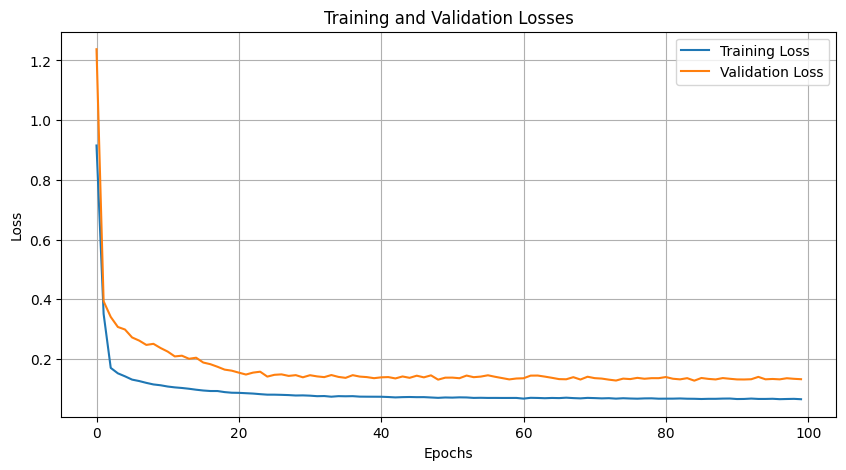

/tmp/ipykernel_31/3105391348.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
Testing: 100%|████


FINAL TEST RESULTS
Loss:     0.0497
MAE:      0.1212
RMSE:     0.2231
R²:       0.9287


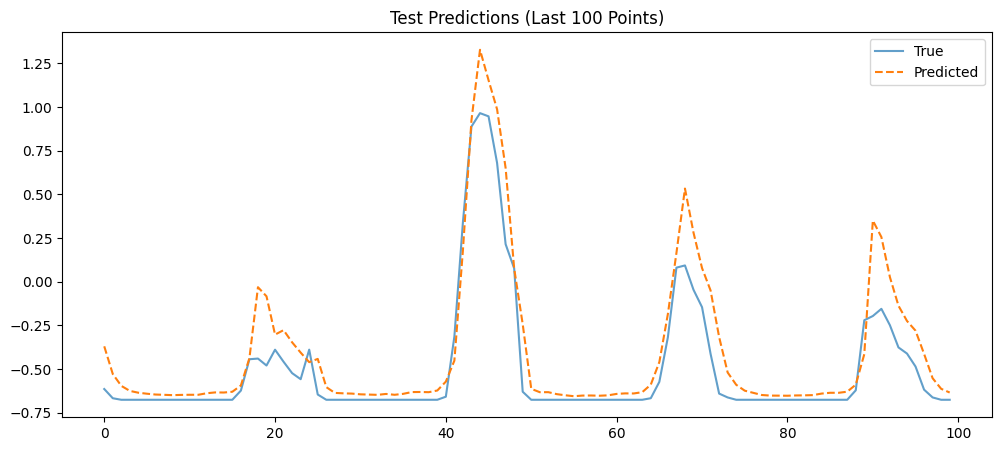

In [64]:
torch.save(model.state_dict(), 'energy_generation_model.pth')

print("Model saved and Running final evaluation...")
# 1. Tracer les courbes d'apprentissage
plot_losses()

# 2. Évaluation finale sur le test set
test_results = test_model()

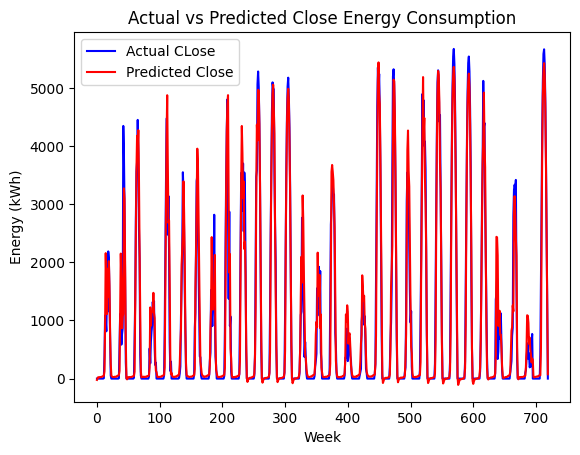

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [65]:
# Assure que le modèle est sur le CPU
model_cpu = model.to('cpu')
model_cpu.eval()

# Assure que les données sont sur le CPU aussi
X_train_cpu = X_train.to('cpu')

with torch.no_grad():
    predicted = model_cpu(X_train_cpu).numpy()


train_predictions_normalized = predicted.flatten()
train_predictions = scaler.inverse_transform(train_predictions_normalized.reshape(-1, 1))

Y_train_normal = scaler.inverse_transform(Y_train.reshape(-1, 1))

plt.plot(Y_train_normal[-24*30*1:], label='Actual CLose', color='blue')
plt.plot(train_predictions[-24*30*1:], label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Energy Consumption')
plt.xlabel('Week')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()
# Plot the predicted values
plt.figure(figsize=(10, 5))

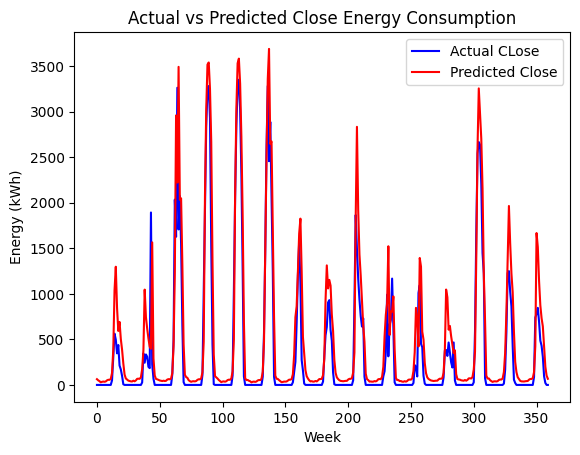

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [67]:
# Assure que les données sont sur le CPU aussi
X_test_cpu = X_test.to('cpu')

with torch.no_grad():
    predicted = model_cpu(X_test_cpu).numpy()


test_predictions_normalized = predicted.flatten()
test_predictions = scaler.inverse_transform(test_predictions_normalized.reshape(-1, 1))

Y_test_normal = scaler.inverse_transform(Y_test.reshape(-1, 1))

plt.plot(Y_test_normal[-24*15*1:], label='Actual CLose', color='blue')
plt.plot(test_predictions[-24*15*1:], label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Energy Consumption')
plt.xlabel('Week')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()
# Plot the predicted values
plt.figure(figsize=(10, 5))